In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision

from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("darkgrid")

from mean_teacher import datasets, architectures
from mean_teacher.utils import *

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
to_image = transforms.ToPILImage()

%matplotlib inline

In [2]:
def load_weights(model_arch, pretrained_model_path, state_dict, cuda=True):
        # Load pretrained model
        pretrained_model = torch.load(f=pretrained_model_path, map_location="cuda" if cuda else "cpu")

        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in pretrained_model[state_dict].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        # Load pre-trained weights in current model
        with torch.no_grad():
            model_arch.load_state_dict(new_state_dict, strict=True)

        # Debug loading
        #print('Parameters found in pretrained model:')
        pretrained_layers = new_state_dict.keys()
        #for l in pretrained_layers:
        #    print('\t' + l)
        #print('')

        for name, module in model_arch.state_dict().items():
            if name in pretrained_layers:
                assert torch.equal(new_state_dict[name].cpu(), module.cpu())
                #print('{} have been loaded correctly in current model.'.format(name))
            else:
                raise ValueError("state_dict() keys do not match")
                
        return model_arch


In [3]:
dataset_config = datasets.__dict__['ssl4']()

In [4]:
BATCH_SIZE = 256

evaldir = "/scratch/ehd255/ssl_data_96/supervised/val"

eval_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(evaldir, dataset_config['eval_transformation']),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=8,
                                              drop_last=False)


In [150]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy@k for the specified values of k"""
    maxk = max(topk)
    labeled_minibatch_size = max(target.ne(-1).sum(), 1e-8).item()

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True).item()
        res.append(correct_k * (100.0 / labeled_minibatch_size))
    return res

In [ ]:
acc = []

with torch.no_grad():
    for ckpt in tqdm([0, 30, 60, 100]):
        model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(ckpt) 
        ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)
        ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False).to(device)

        for img, target in eval_loader:
            img, target = img.to(device), target.to(device)

            out = ema_model(img)[0]
            acc.append(accuracy(out, target, topk=(1,5)))


  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
img_num = 19210

img_dir = eval_loader.dataset.imgs[img_num][0]
img = eval_loader.dataset[img_num][0].unsqueeze(0).to(device).detach()
img_class = eval_loader.dataset[img_num][1]

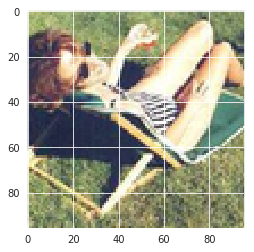

In [74]:
plt.imshow(io.imread(eval_loader.dataset.imgs[19210][0]))

In [73]:
eval_loader.dataset.imgs[19210][1]

300

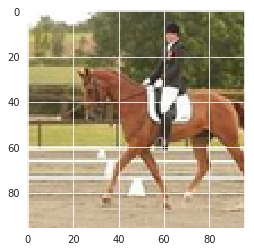

In [37]:
plt.imshow(io.imread(img_dir))

In [21]:
model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 

model = architectures.__dict__['cifar_shakeshake26']().to(device)
ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

with torch.no_grad():
    model_out = F.softmax(model(img)[0], dim=1)
    ema_model_out = F.softmax(ema_model(img)[0], dim=1)

dists = torch.cat((model_out, ema_model_out)).unsqueeze(0)

with torch.no_grad():
    for ckpt in tqdm(range(5, 105, 5)):
        model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(ckpt) 
        
        model = architectures.__dict__['cifar_shakeshake26']().to(device)
        ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

        model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
        ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

        model_out = F.softmax(model(img)[0], dim=1)
        ema_model_out = F.softmax(ema_model(img)[0], dim=1)

        outs = torch.cat((model_out, ema_model_out)).unsqueeze(0)
        dists = torch.cat((dists, outs))
     

100%|██████████| 20/20 [01:36<00:00,  4.46s/it]


In [81]:
dists.size()

torch.Size([5, 2, 1000])

In [19]:
select_labels = [0] + np.sort(np.random.choice(np.arange(0, 1000), 9, replace=False)).tolist()

In [91]:
colors = sns.color_palette('pastel', 4)

In [22]:
labels = pd.DataFrame(dists[0].numpy())
labels.index = ['Student', 'Teacher']
labels.index.name = "Model"
    
labels_melt = pd.melt(labels.reset_index(), id_vars = ["Model"], var_name="Label", value_name="Probability")
labels_melt['Ckpt'] = 0

ckpts = np.arange(0, 105, 5)

for i in range(1, dists.size(0)):
    labels = pd.DataFrame(dists[i].numpy())
    labels.index = ['Student', 'Teacher']
    labels.index.name = "Model"
    
    labels_melt_ = pd.melt(labels.reset_index(), id_vars = ["Model"], var_name="Label", value_name="Probability")
    labels_melt_['Ckpt'] = ckpts[i]
    
    labels_melt = pd.concat([labels_melt, labels_melt_])
    
labels_melt = labels_melt[['Ckpt', "Model", 'Label', "Probability"]]
    

/home/ijh216/pytorch/py3.6.3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 2520x2520 with 0 Axes>

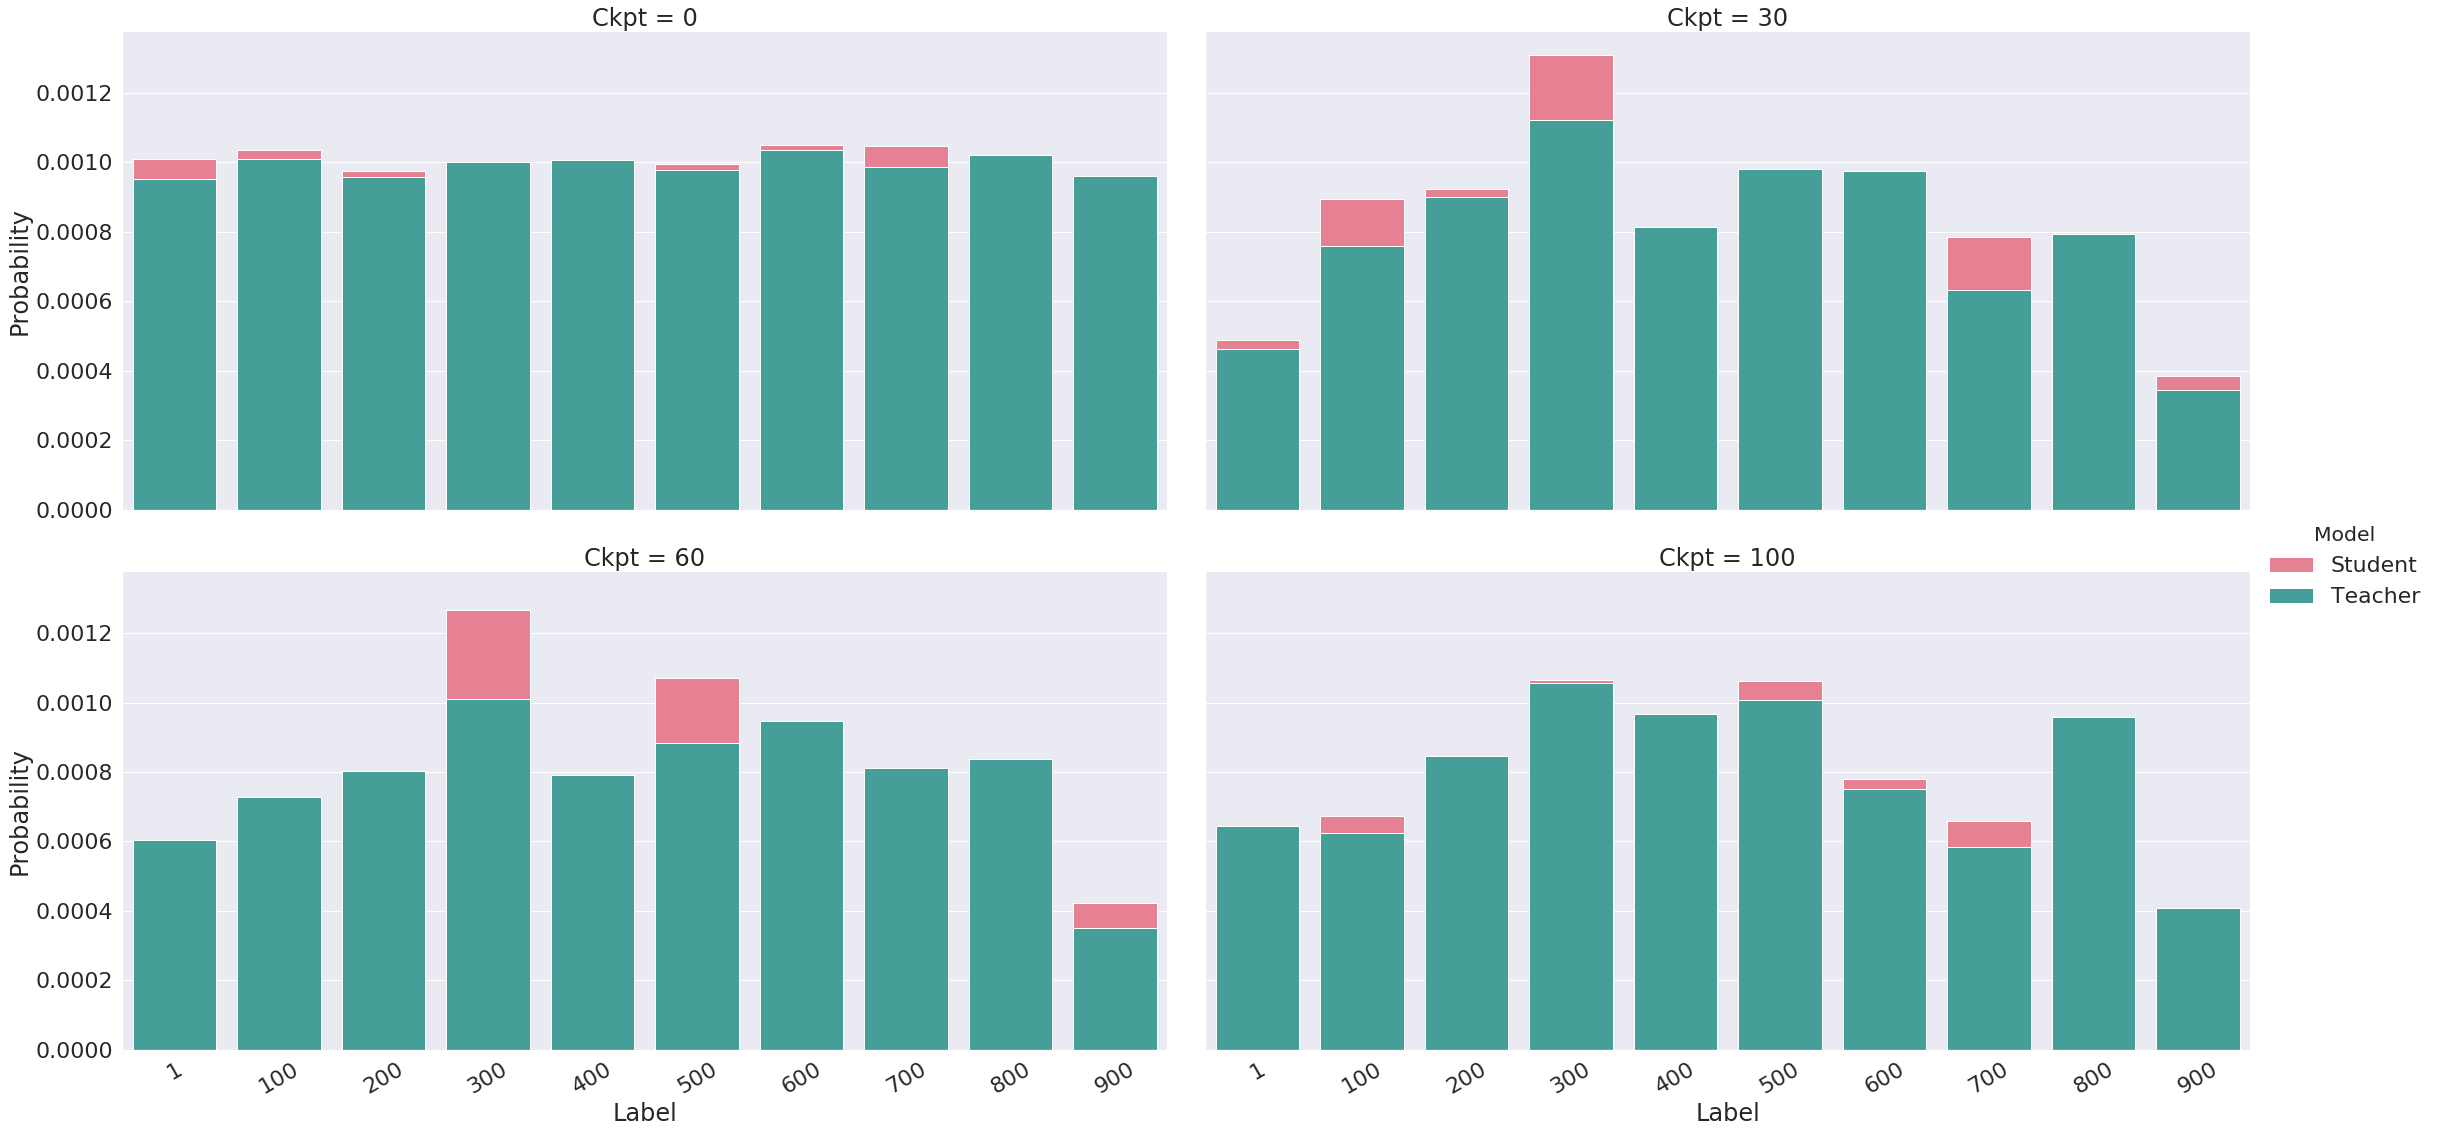

In [145]:
ll_tt = labels_melt.loc[labels_melt['Label'].isin(select_labels)].copy()

fig = plt.figure(figsize=(35,35))
fig.tight_layout()
g = sns.FacetGrid(ll_tt,
                  col='Ckpt',
                  hue='Model', 
                  col_wrap=2,
                  height=8,
                  aspect=2
                 )
g = g.map(sns.barplot, "Label", "Probability", label="Model")
g.set_xticklabels(rotation=30)
g.add_legend()

In [112]:
sns.set_palette(sns.color_palette('husl', 2))

<Figure size 1440x2520 with 0 Axes>

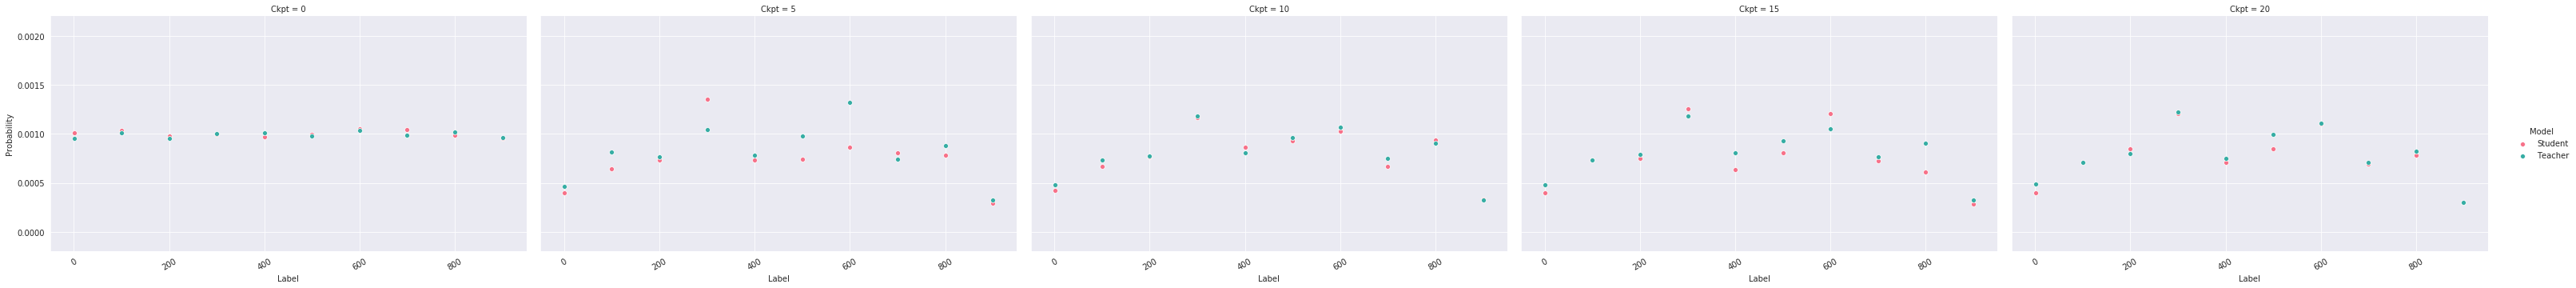

In [117]:
ll_tt = labels_melt.loc[labels_melt['Label'].isin(select_labels)].copy()

fig = plt.figure(figsize=(20,35))
fig.tight_layout()
g = sns.FacetGrid(ll_tt,
                  col='Ckpt',
                  hue='Model', 
                  col_wrap=5,
                  height=5,
                  aspect=1.75
                 )
g = g.map(sns.scatterplot, "Label", "Probability", label="Model")
g.set_xticklabels(rotation=30)
g.add_legend()

In [127]:
plt.rcParams.update({'font.size': 20})

In [12]:
?sns.scatterplot

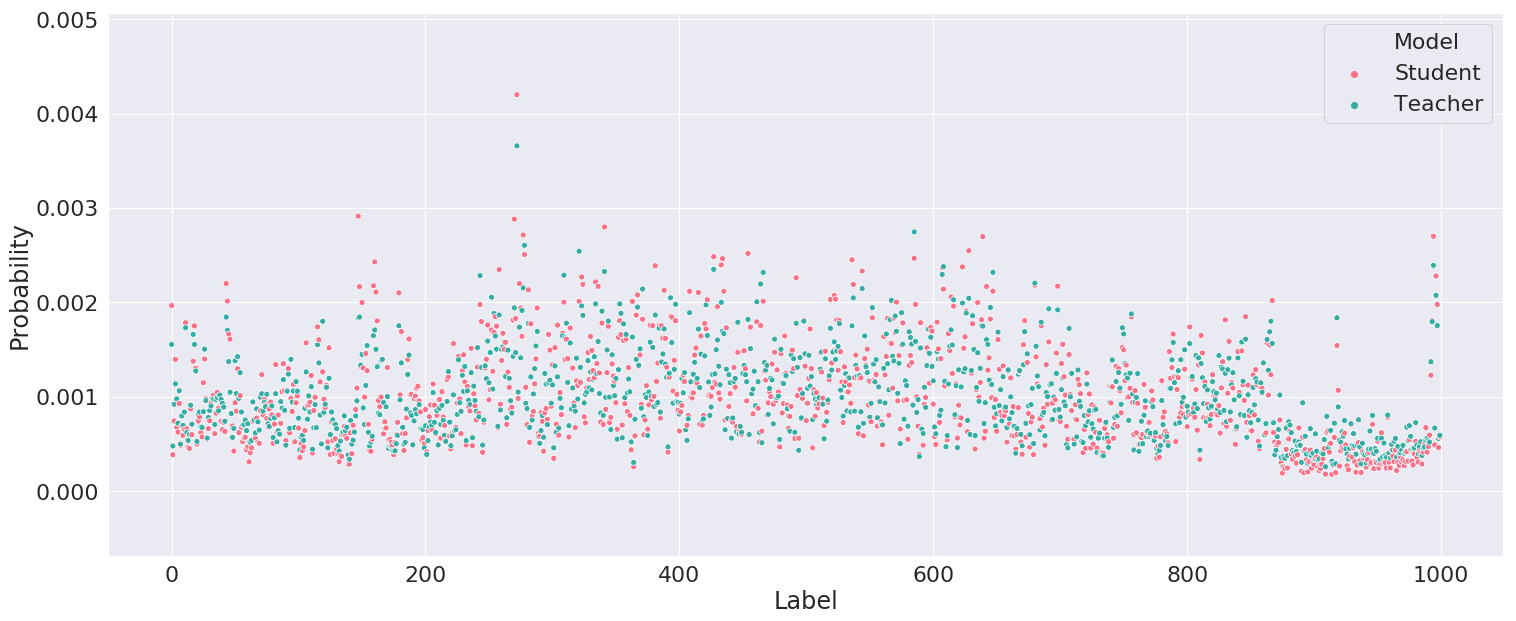

In [25]:
ll_tt = labels_melt.loc[labels_melt['Ckpt']==i].copy()
fig = plt.figure(figsize=(25,10))
sns.scatterplot(data=ll_tt, x='Label', y='Probability', hue="Model")
plt.savefig("saveme.png")

/home/ijh216/pytorch/py3.6.3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


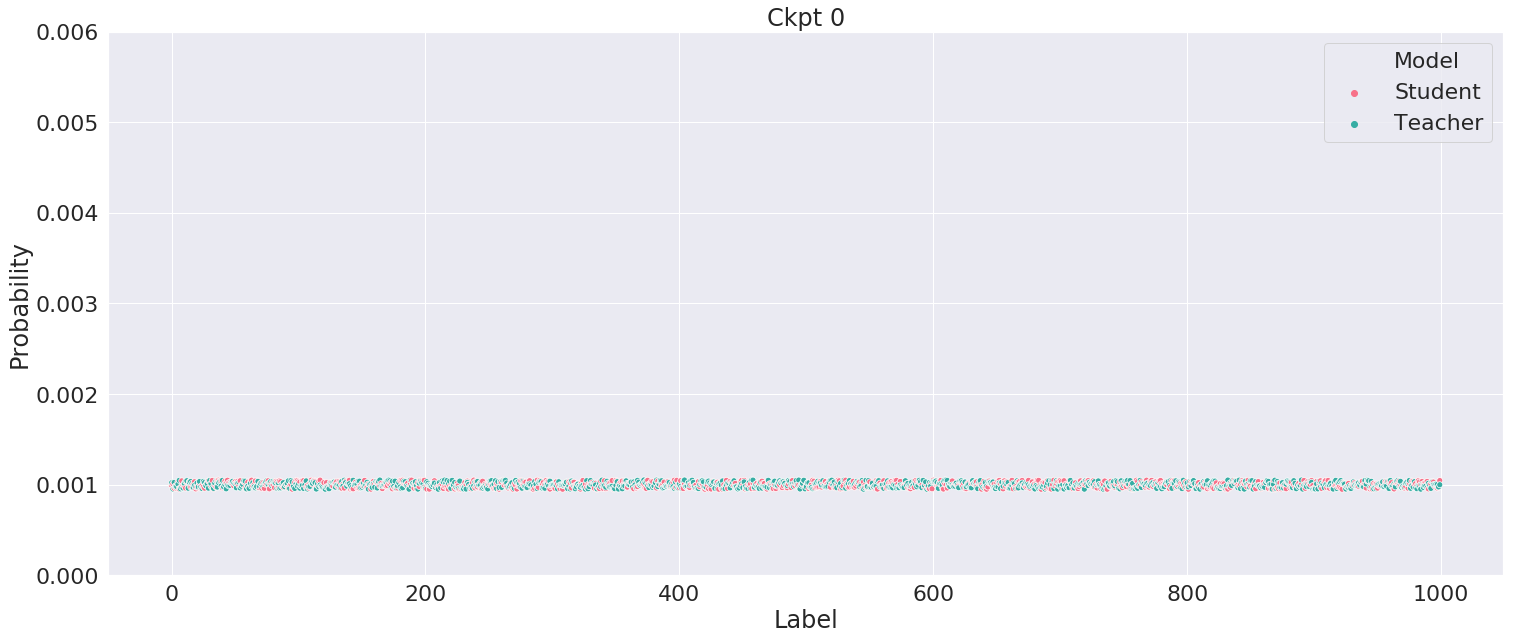

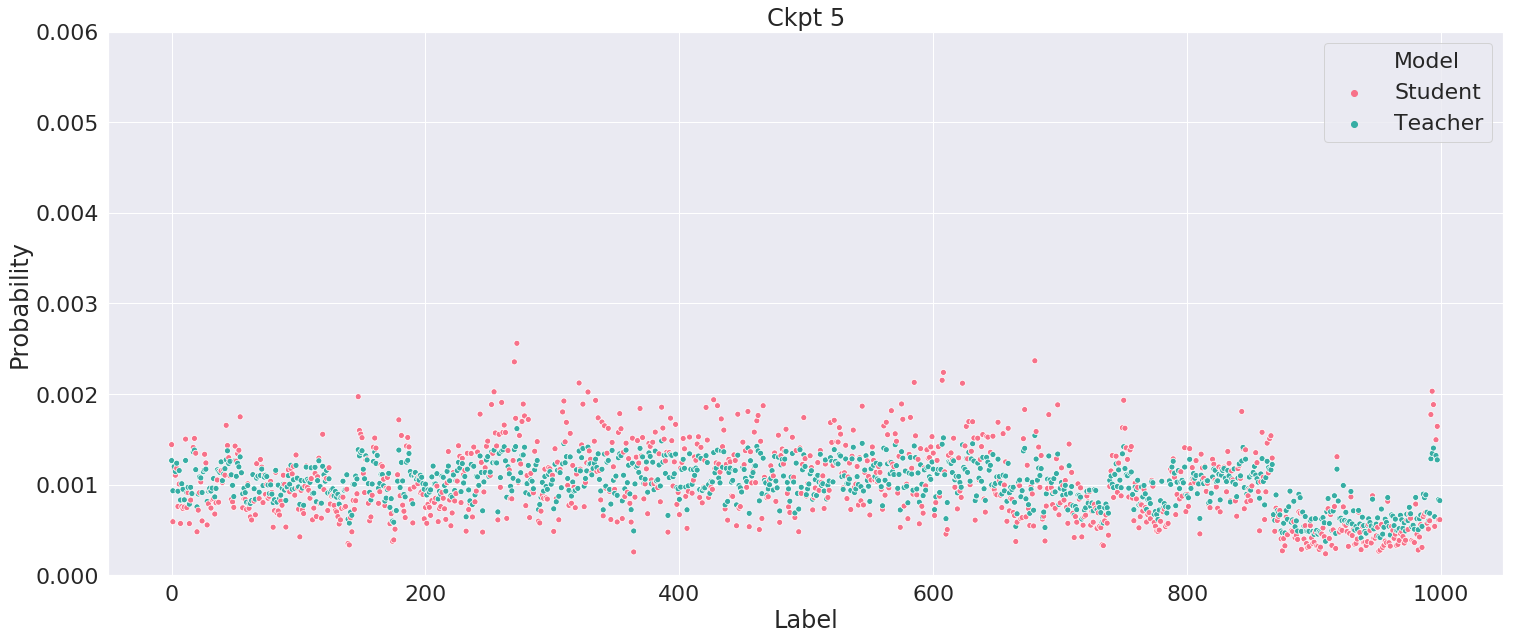

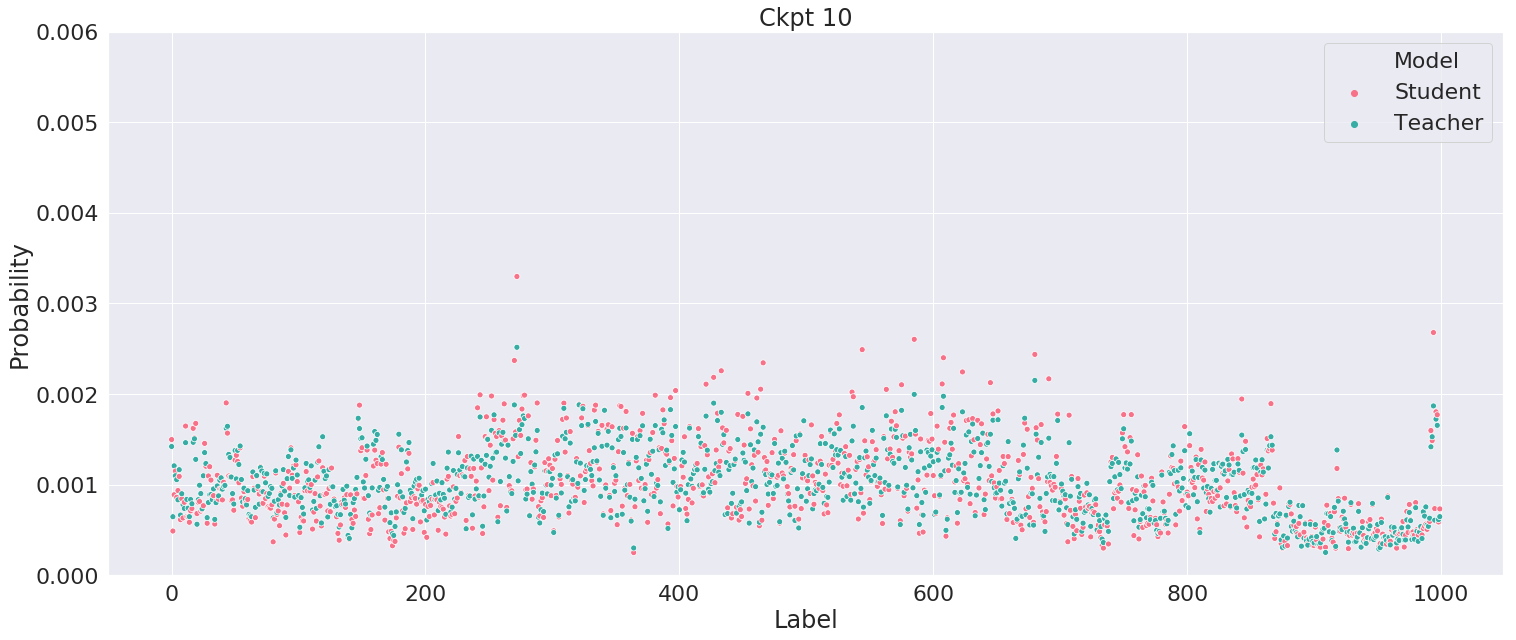

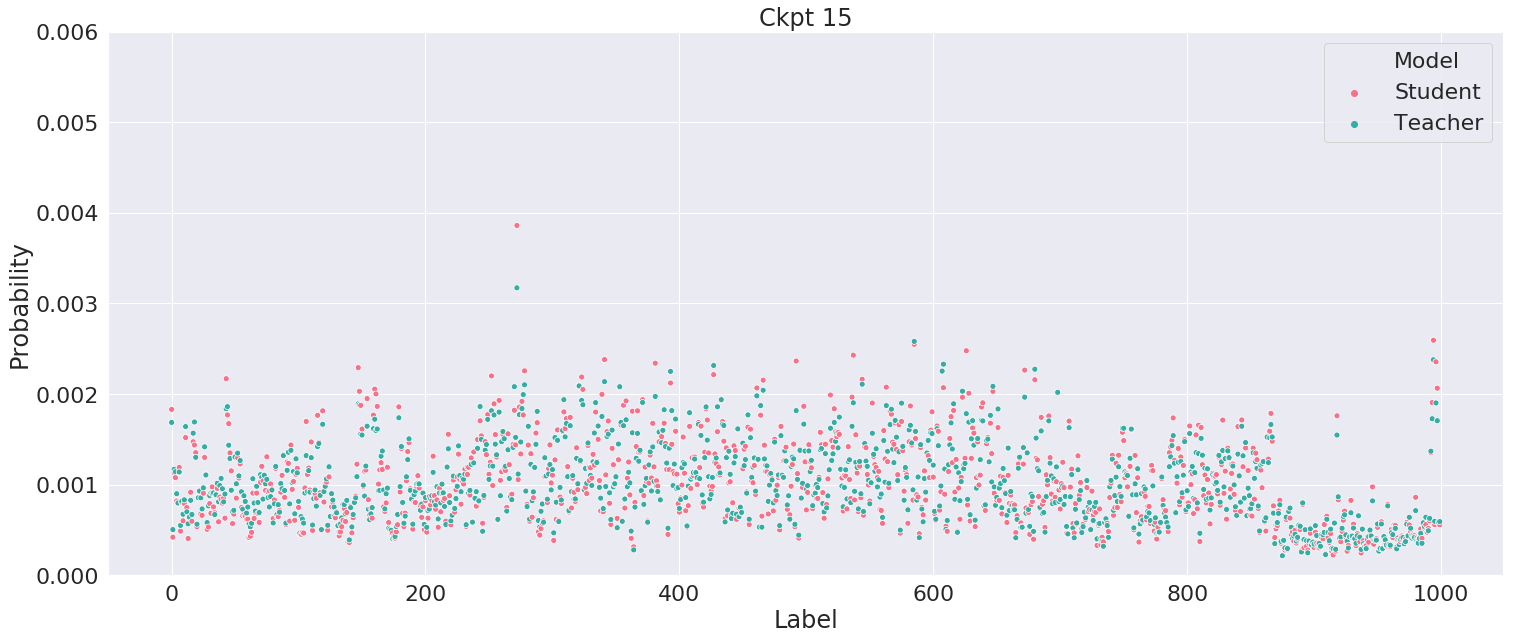

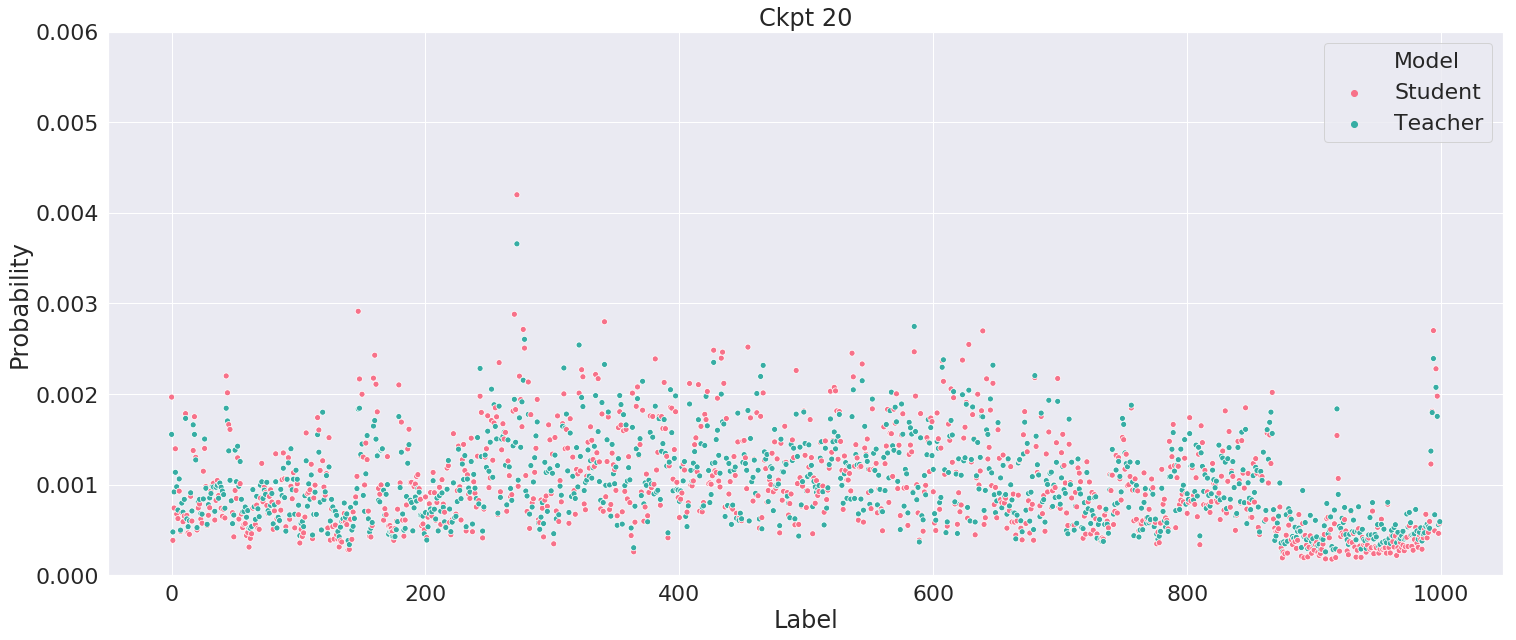

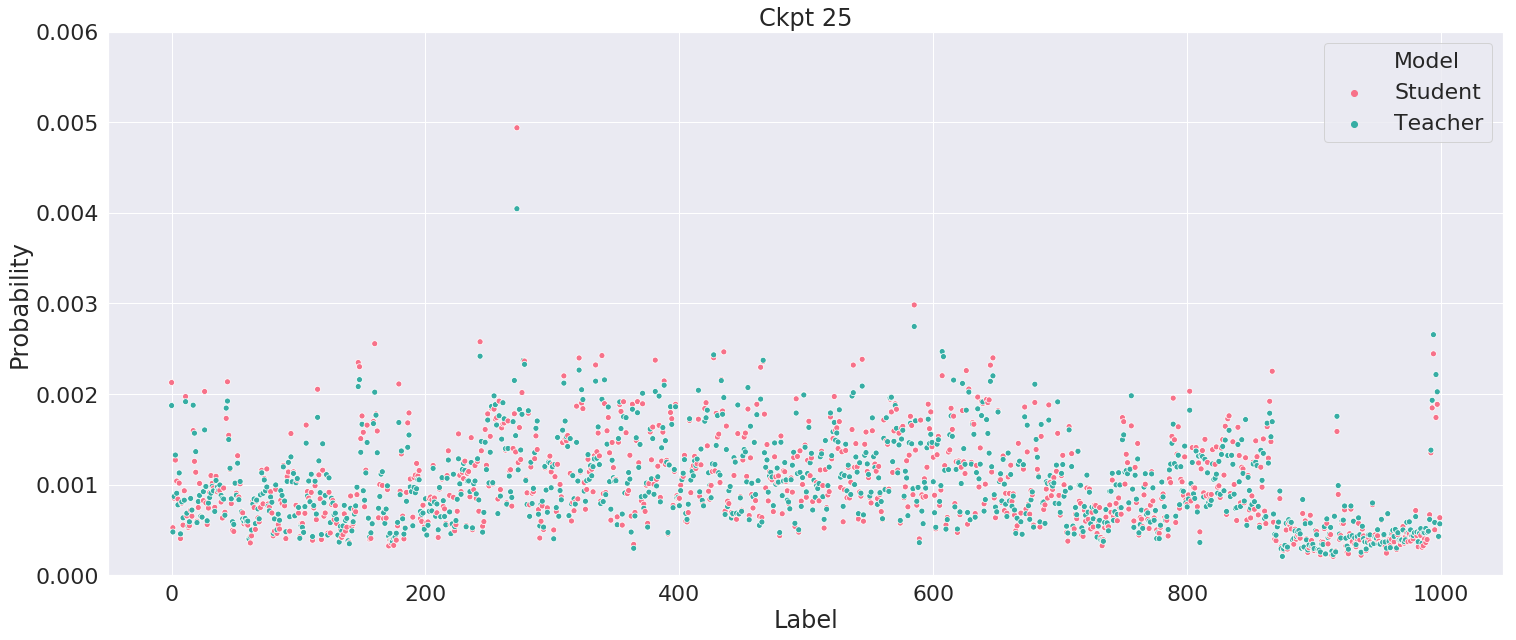

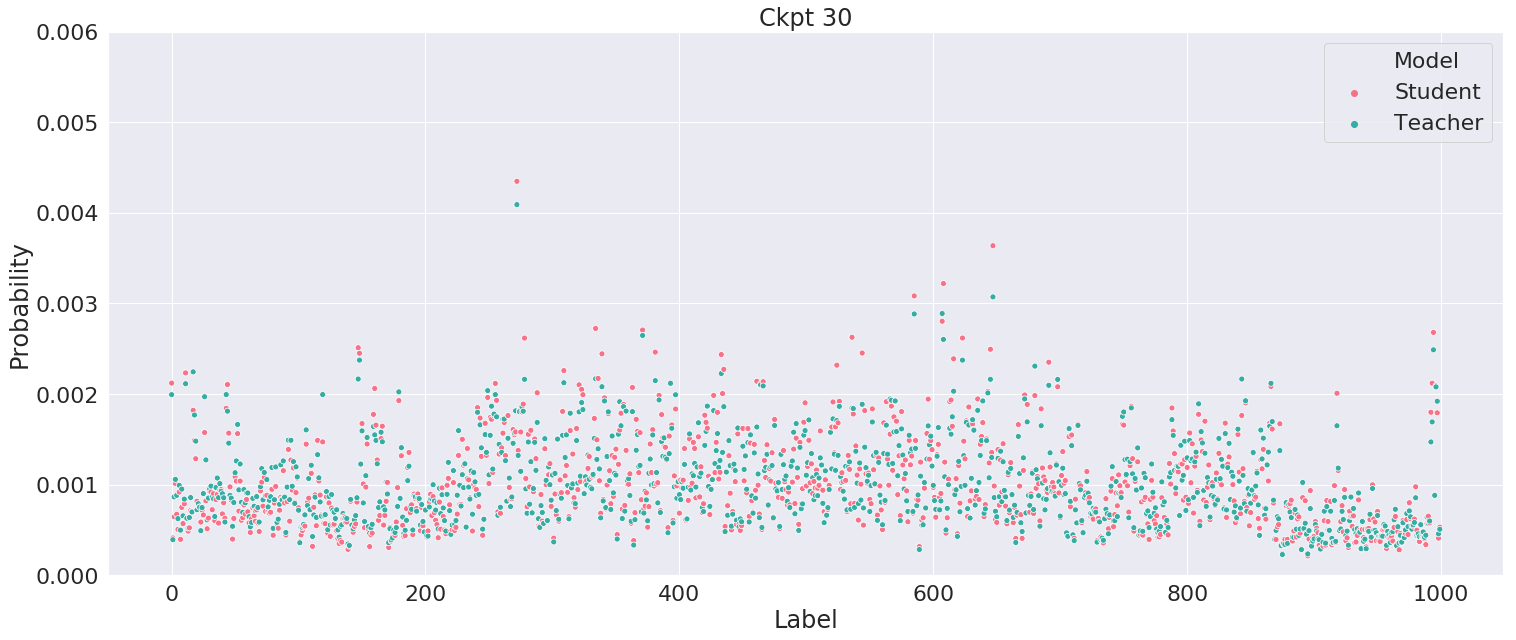

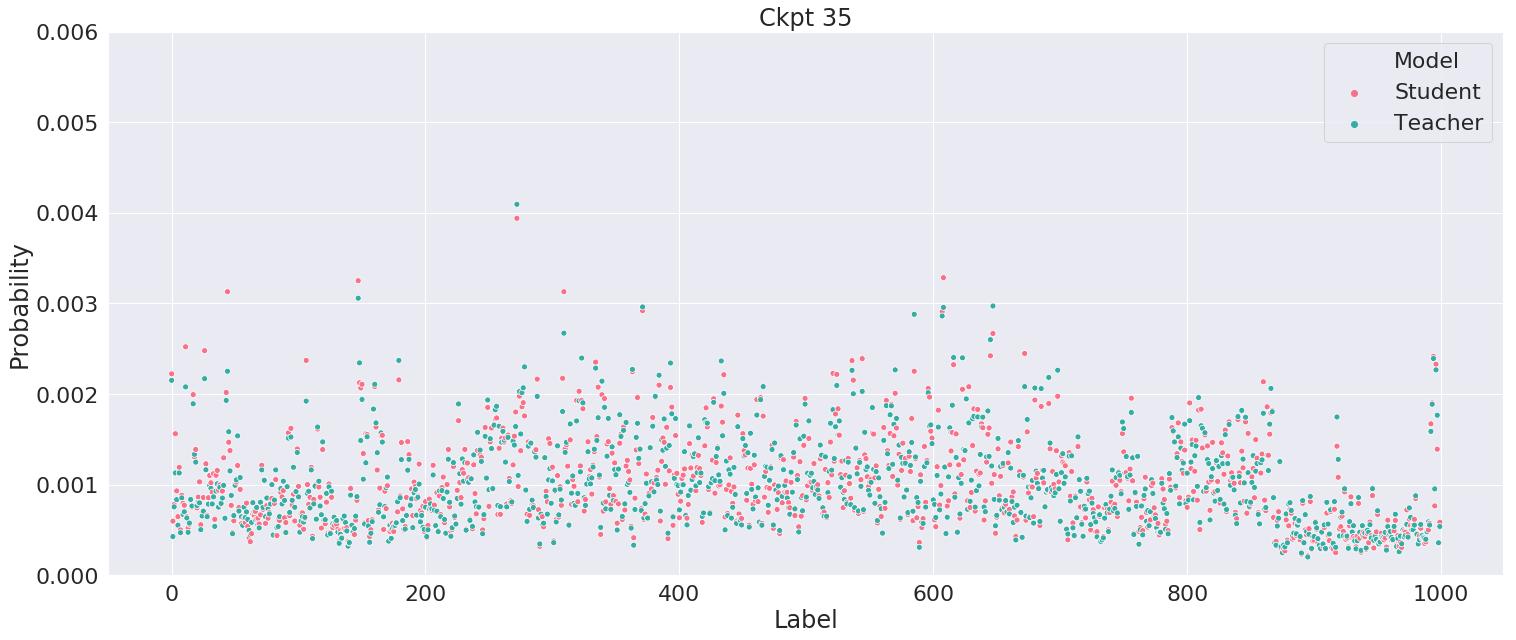

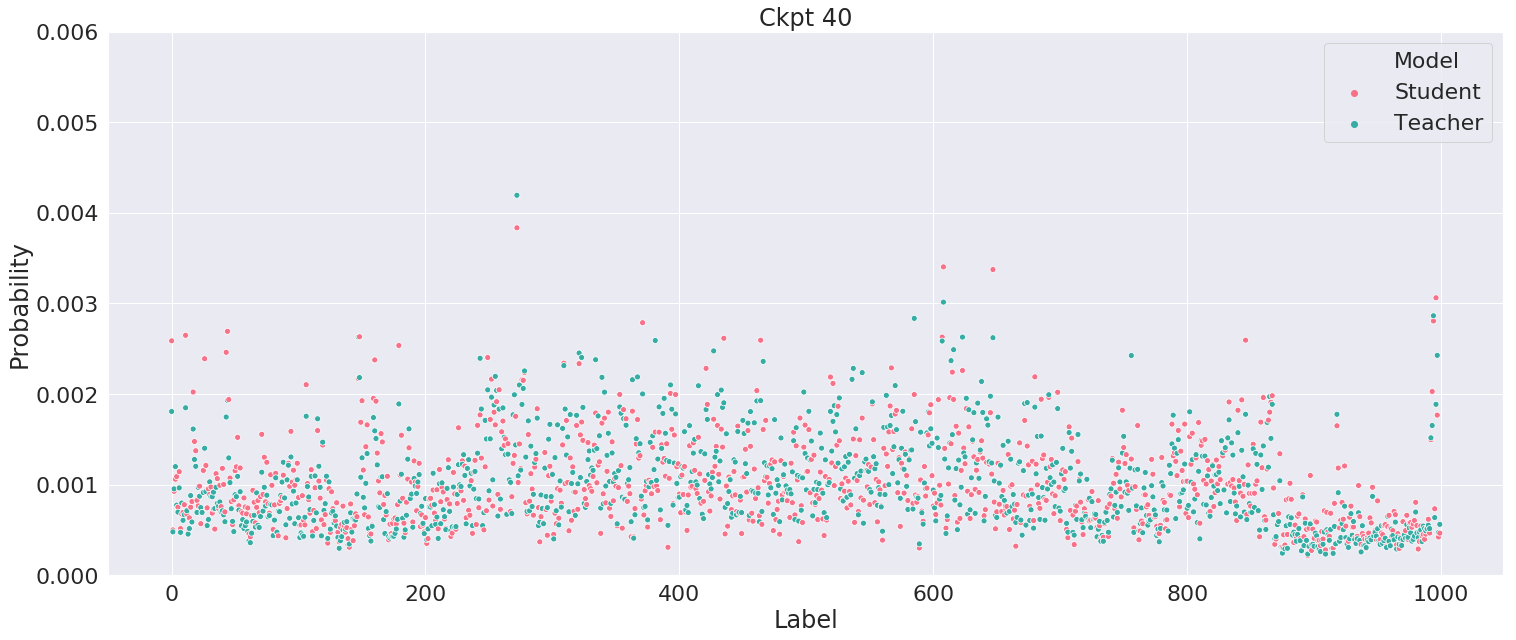

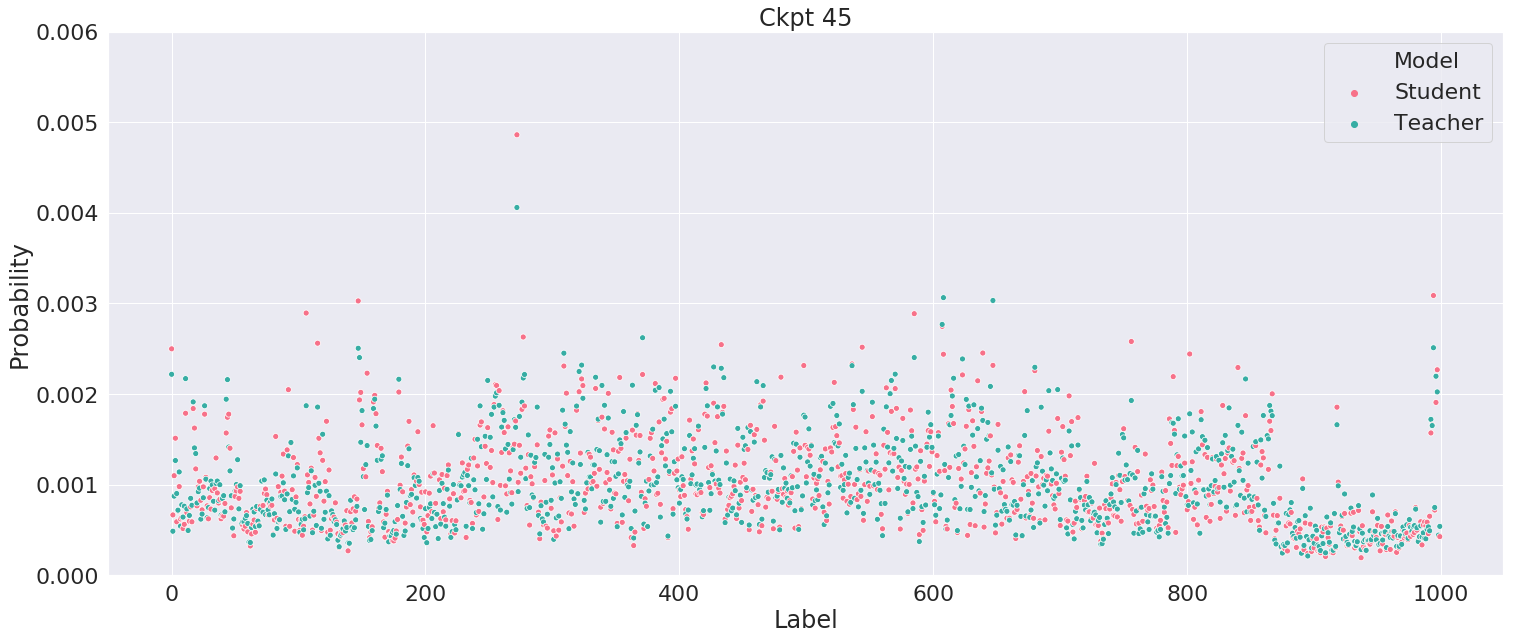

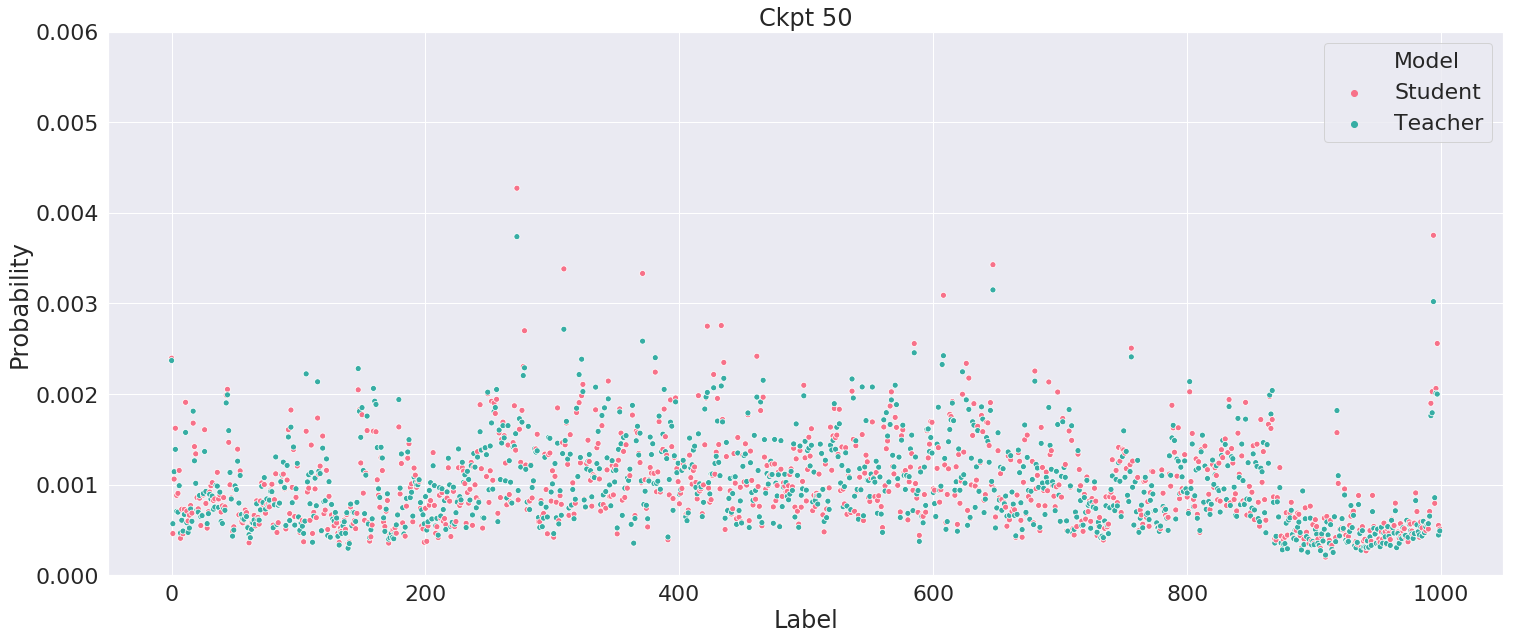

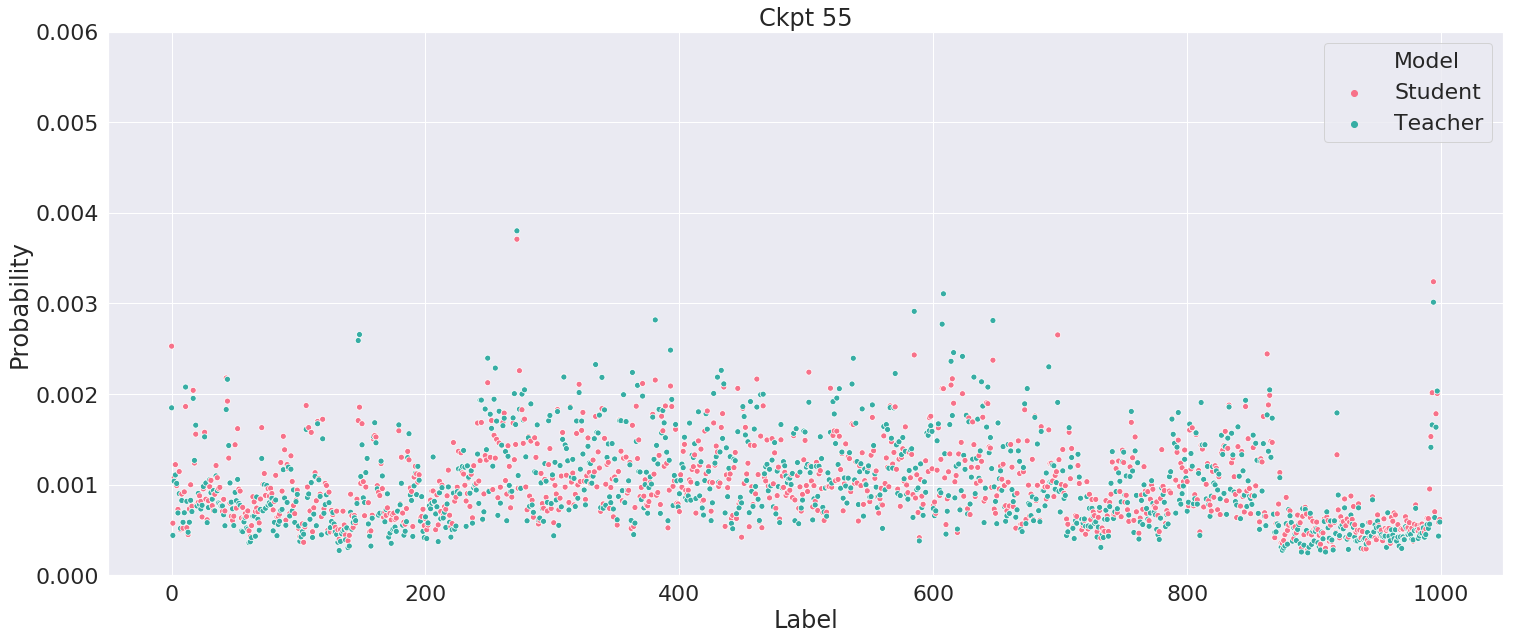

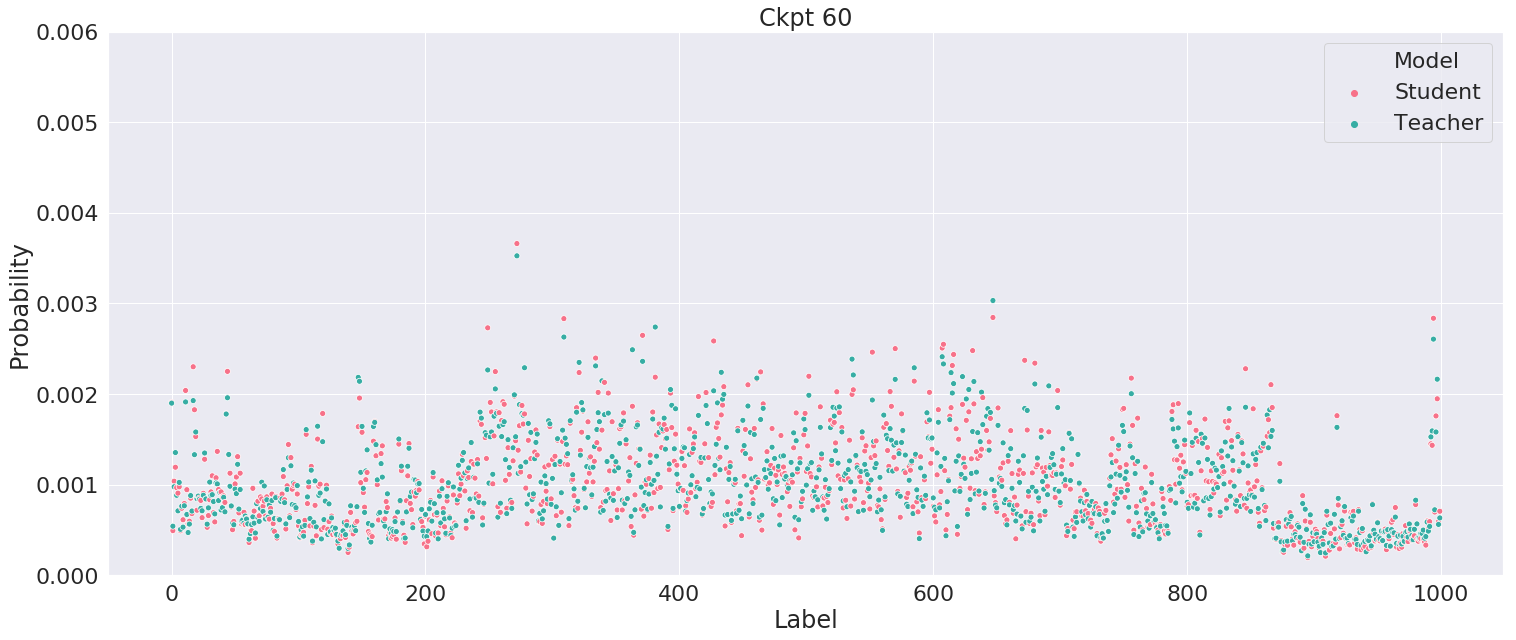

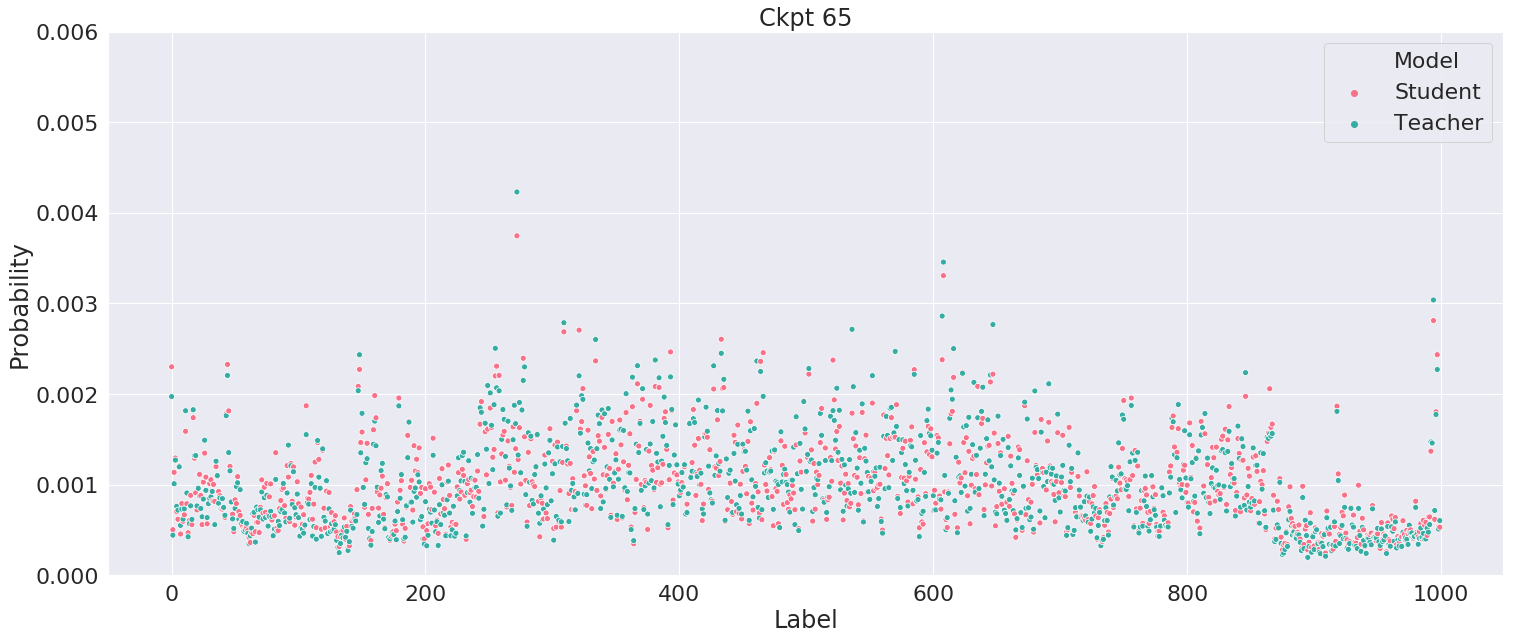

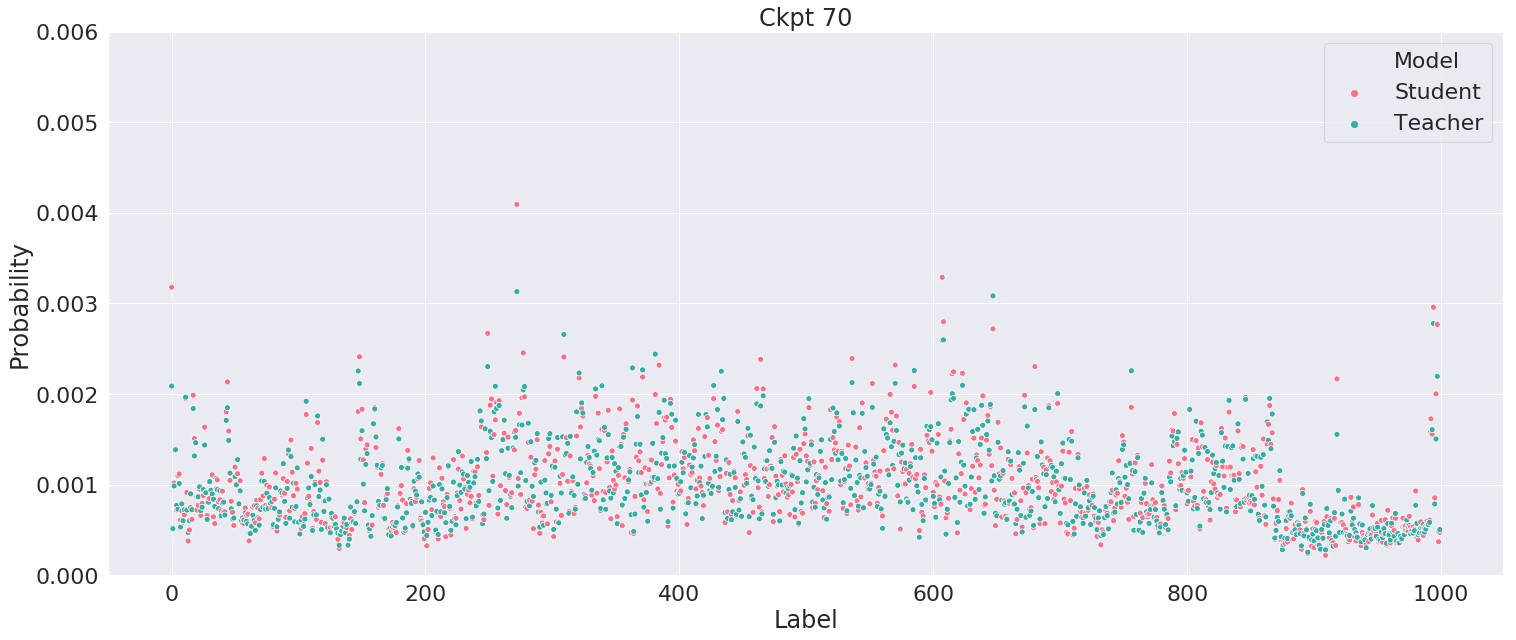

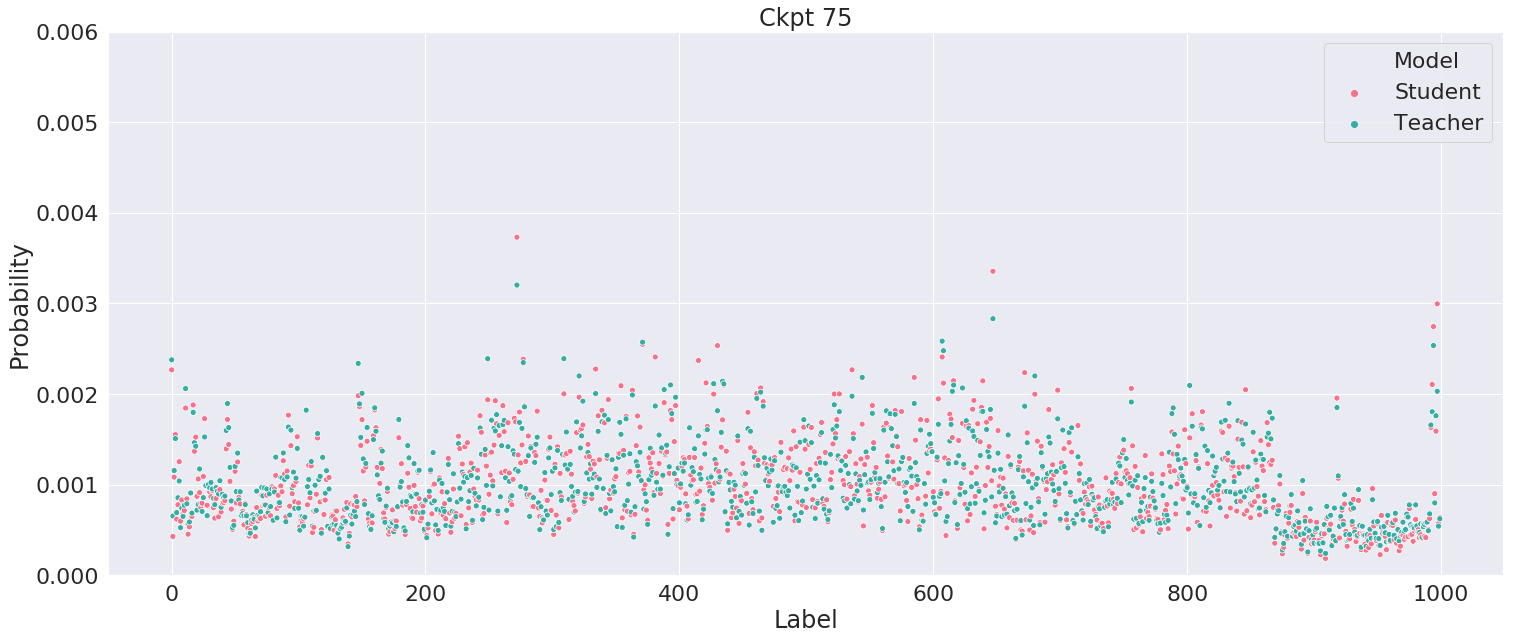

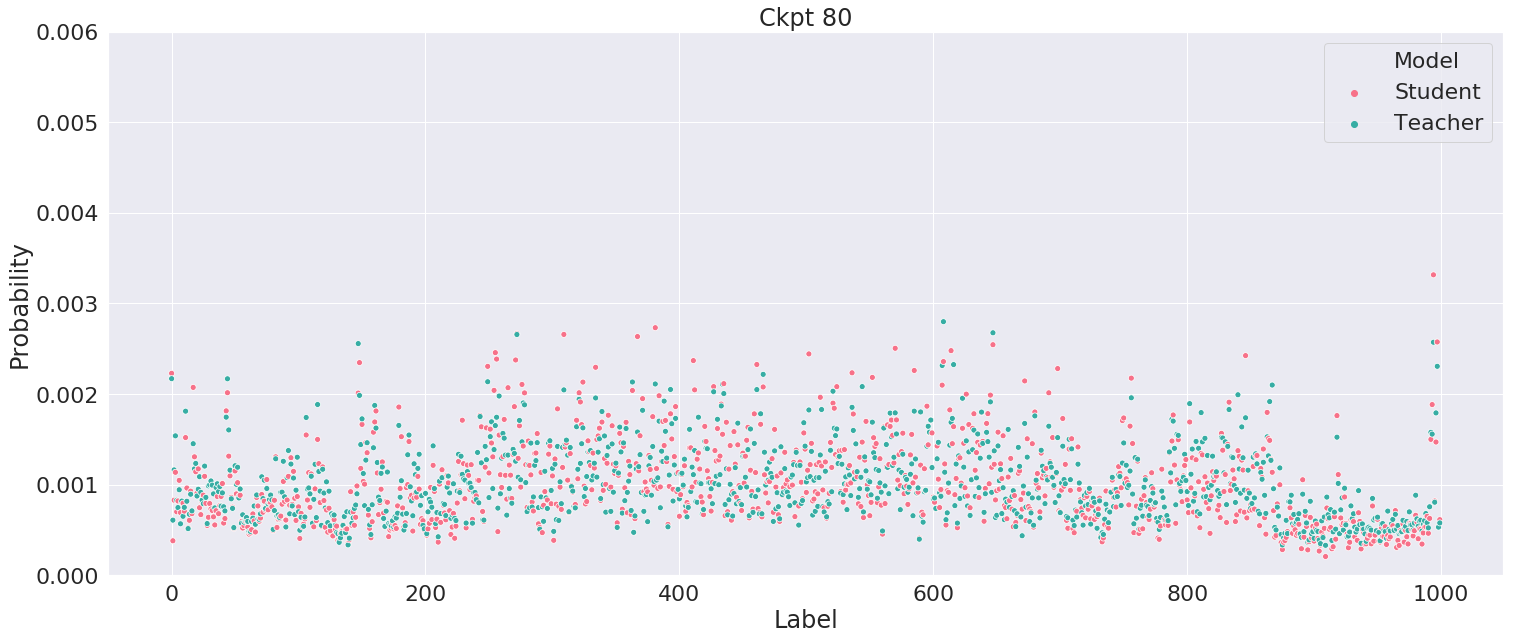

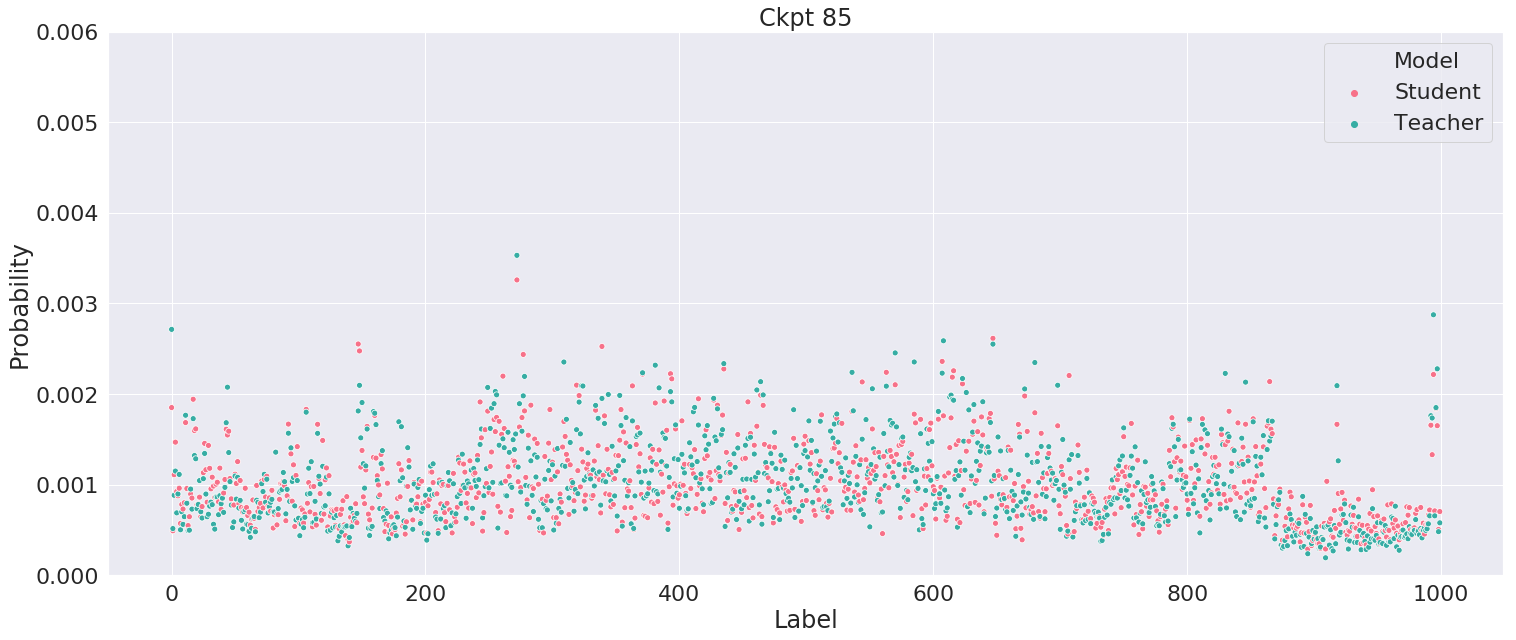

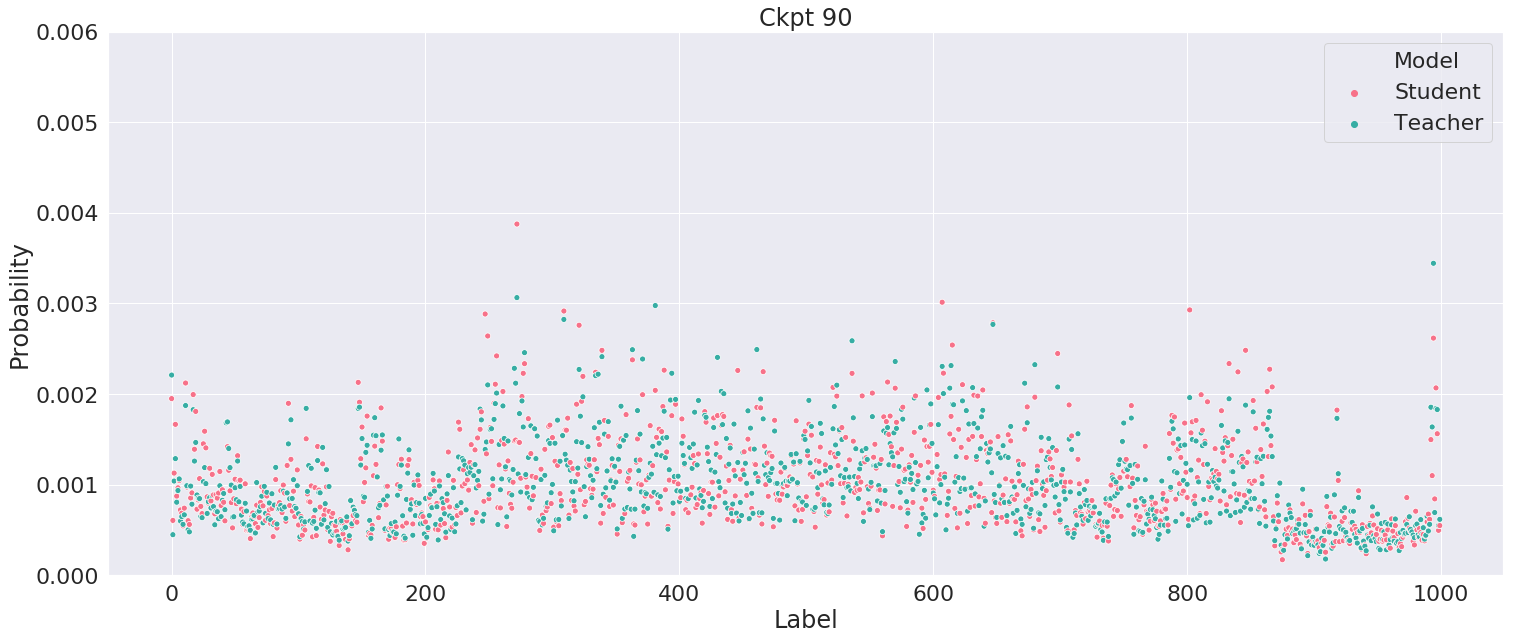

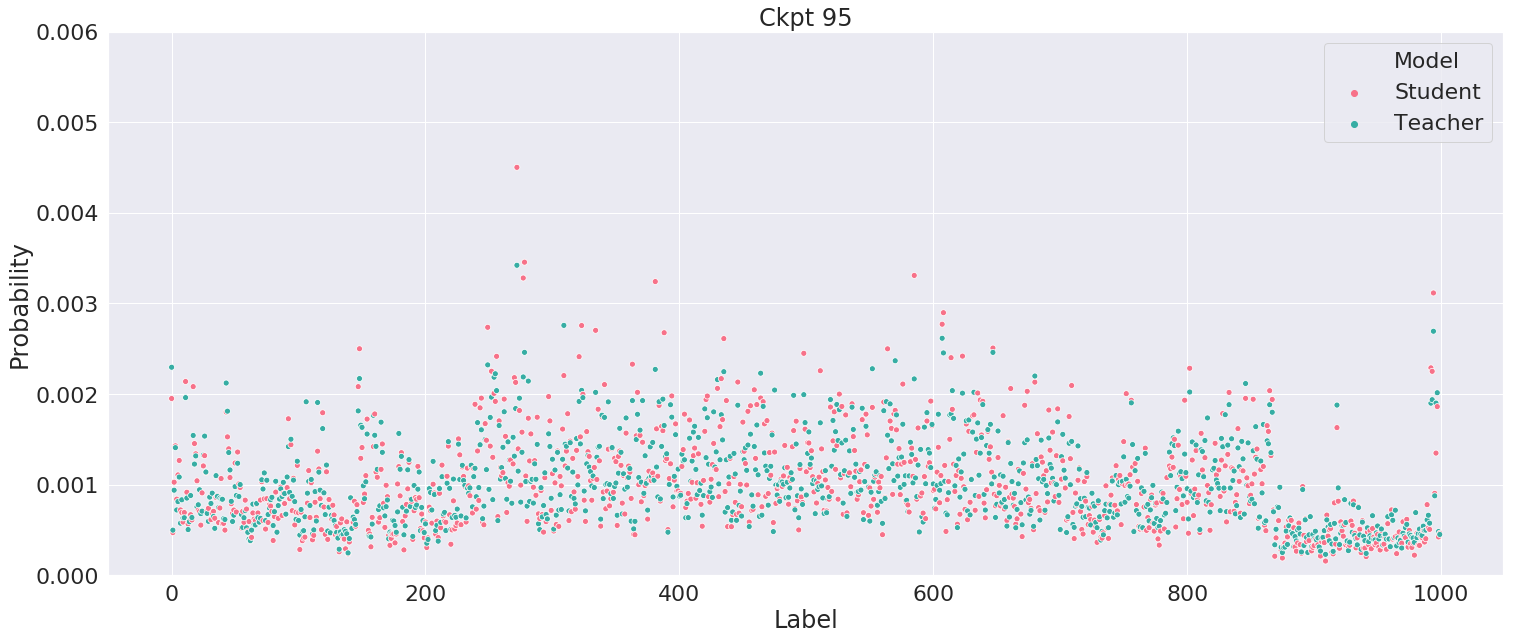

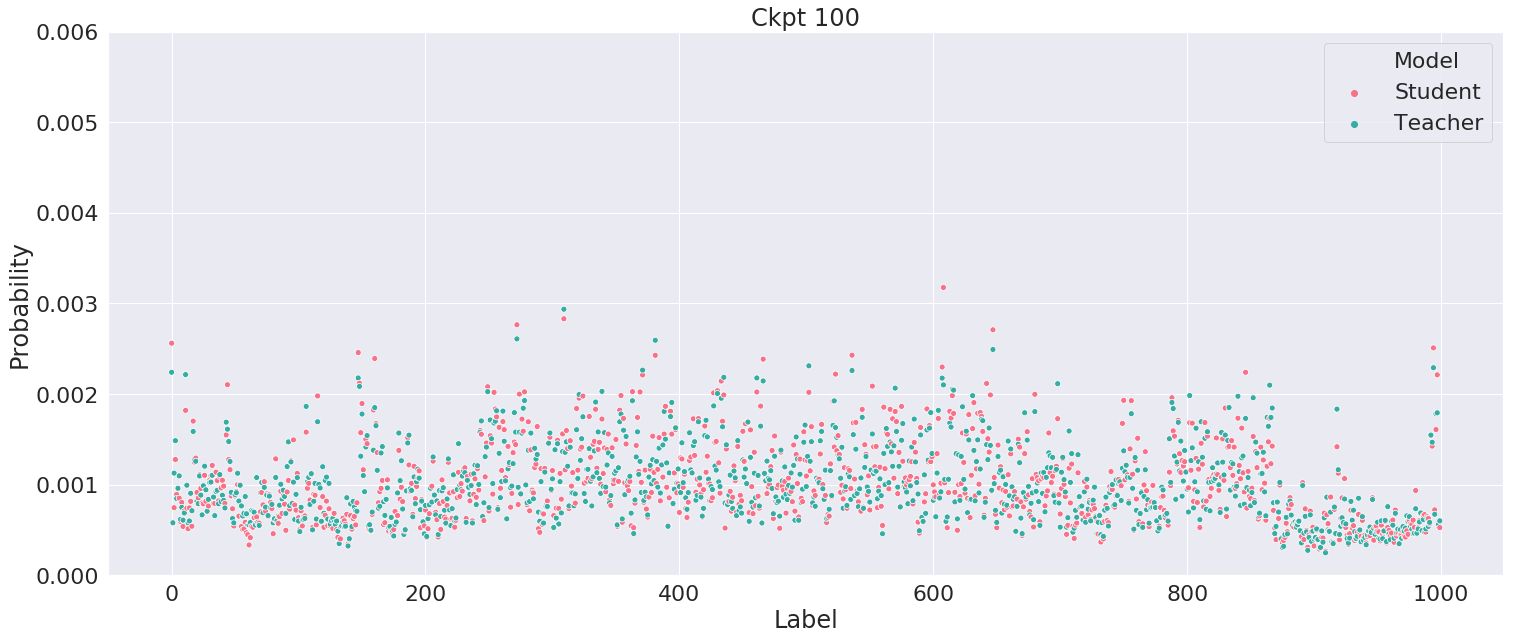

In [36]:
sns.set(font_scale=2)
sns.set_palette(sns.color_palette('husl', 2))

images = []

for i in np.arange(0, 105, 5):
    ll_tt = labels_melt.loc[labels_melt['Ckpt']==i].copy()
    fig = plt.figure(figsize=(25,10))
    sns.scatterplot(data=ll_tt, x='Label', y='Probability', hue="Model")
    plt.ylim((0, 0.006))
    plt.legend()
    plt.title("Ckpt {}".format(i))
    plt.savefig("viz/ckpt{}.png".format(i))
    
    images.append(imageio.imread("viz/ckpt{}.png".format(i)))
    
imageio.mimsave('viz/ckpt.gif', images, fps=5)
    

In [37]:
select_labels = np.arange(0, 1000, 50)

In [40]:
?sns.barplot

/home/ijh216/pytorch/py3.6.3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


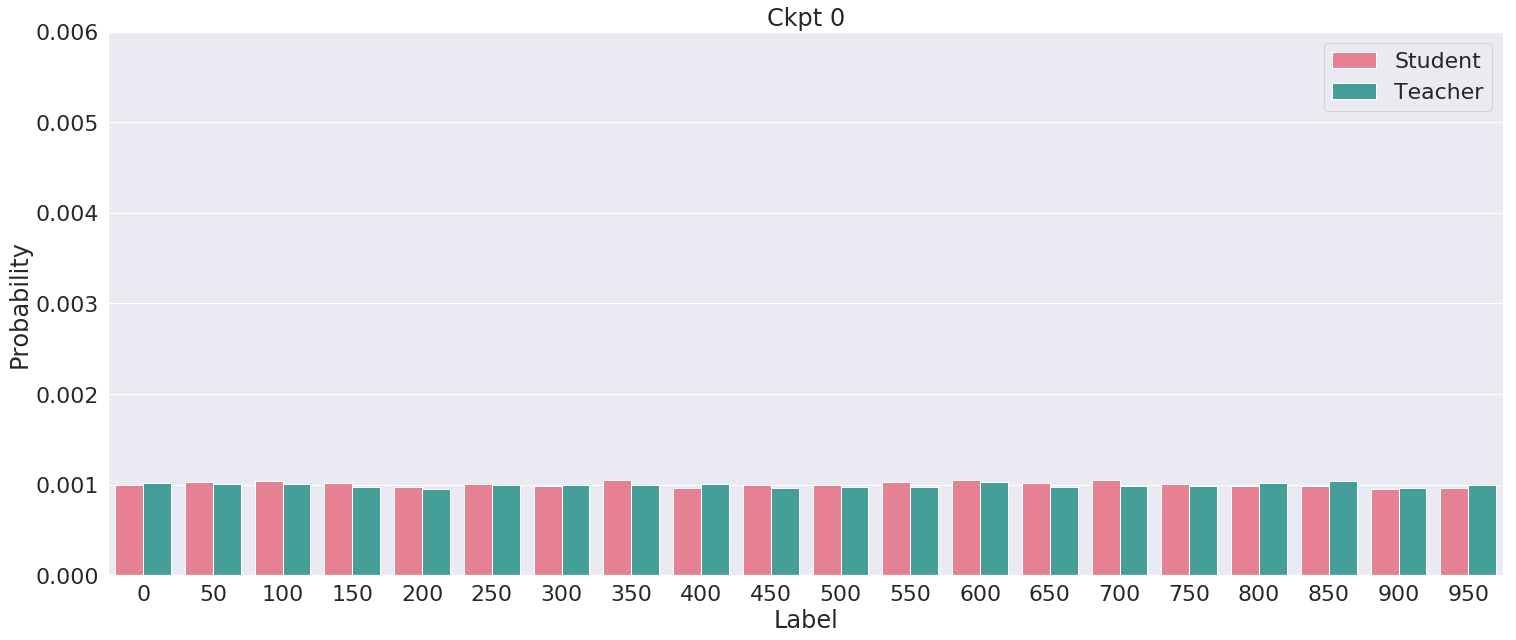

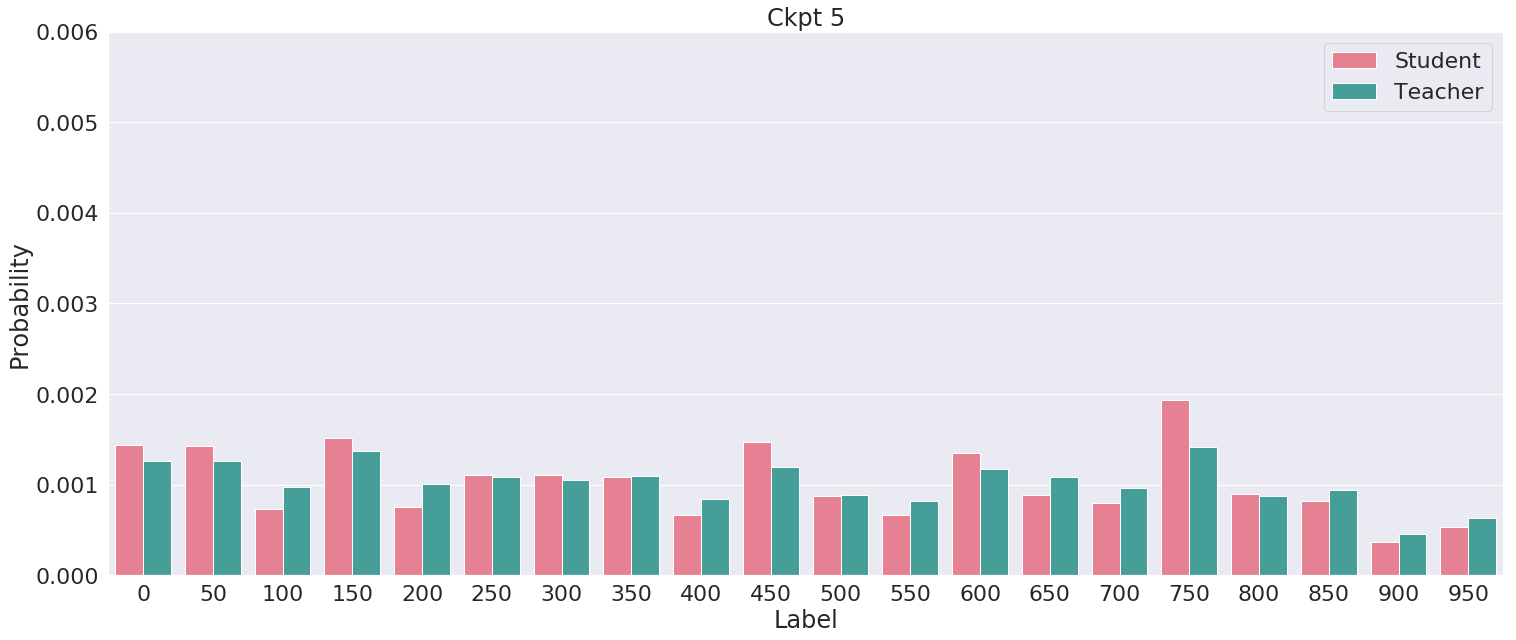

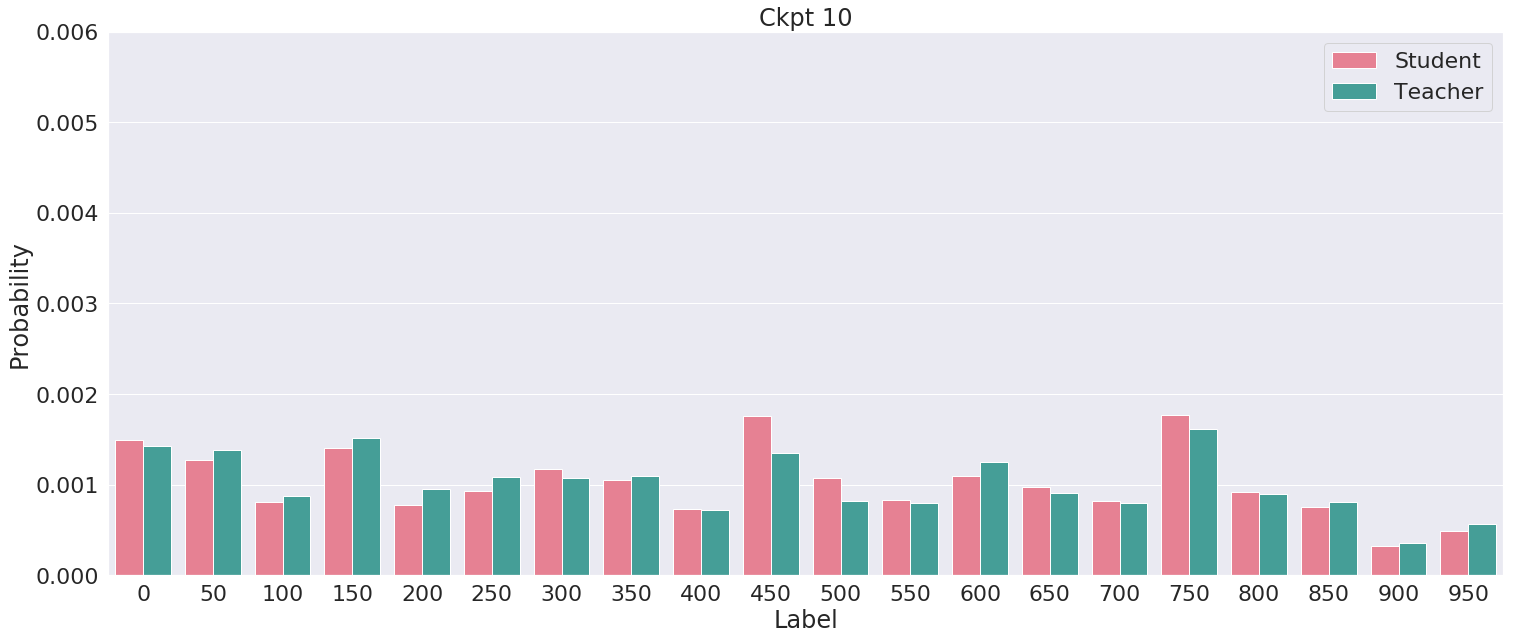

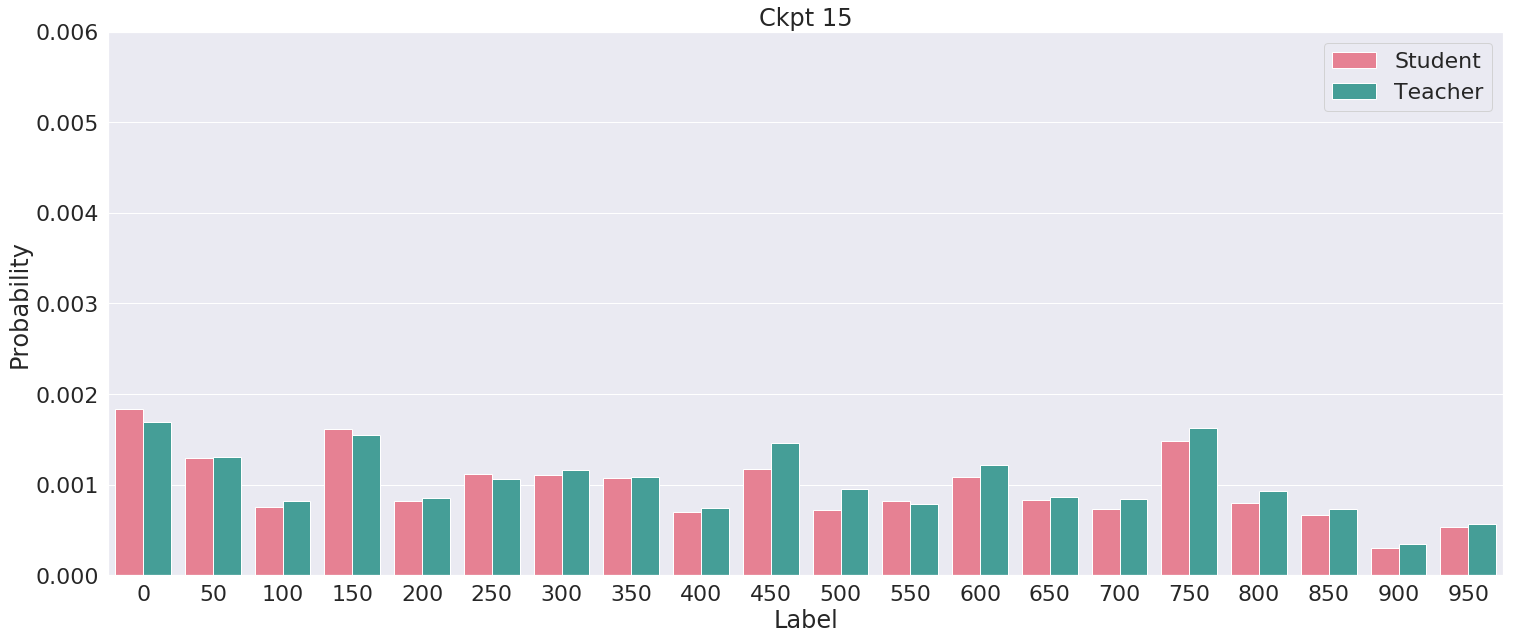

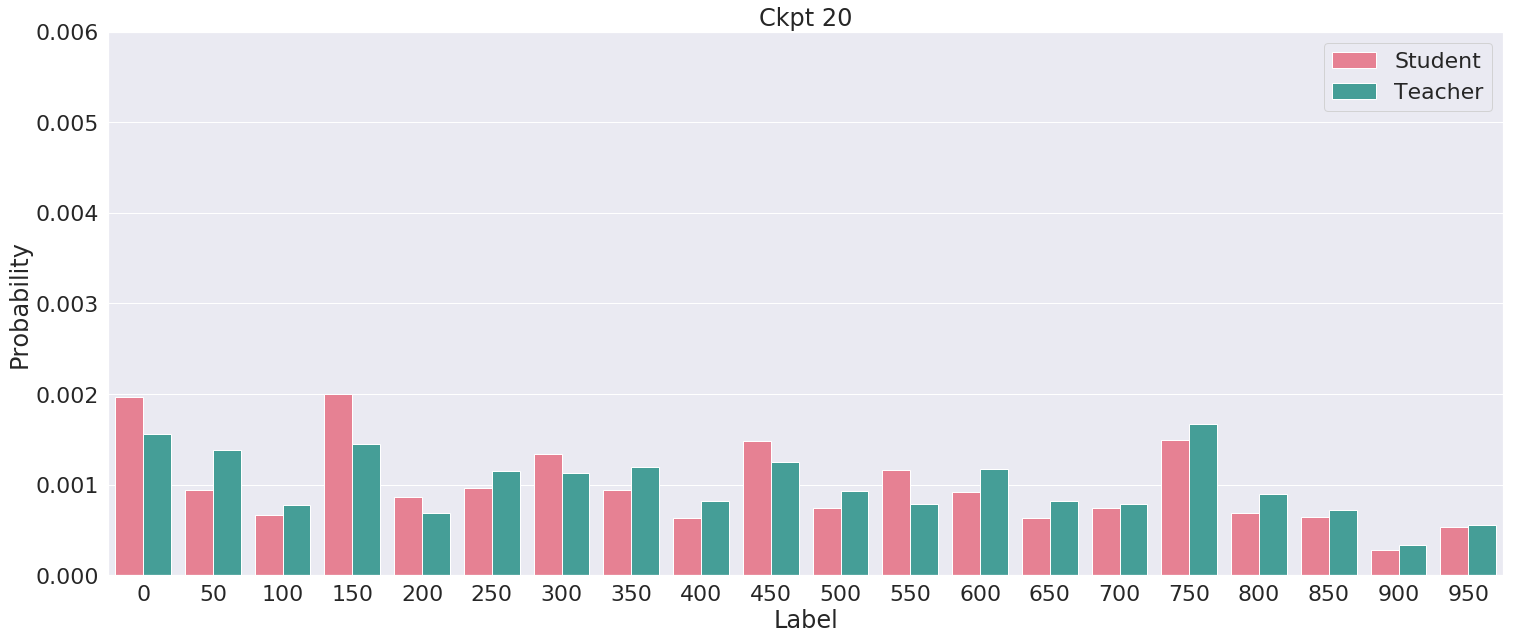

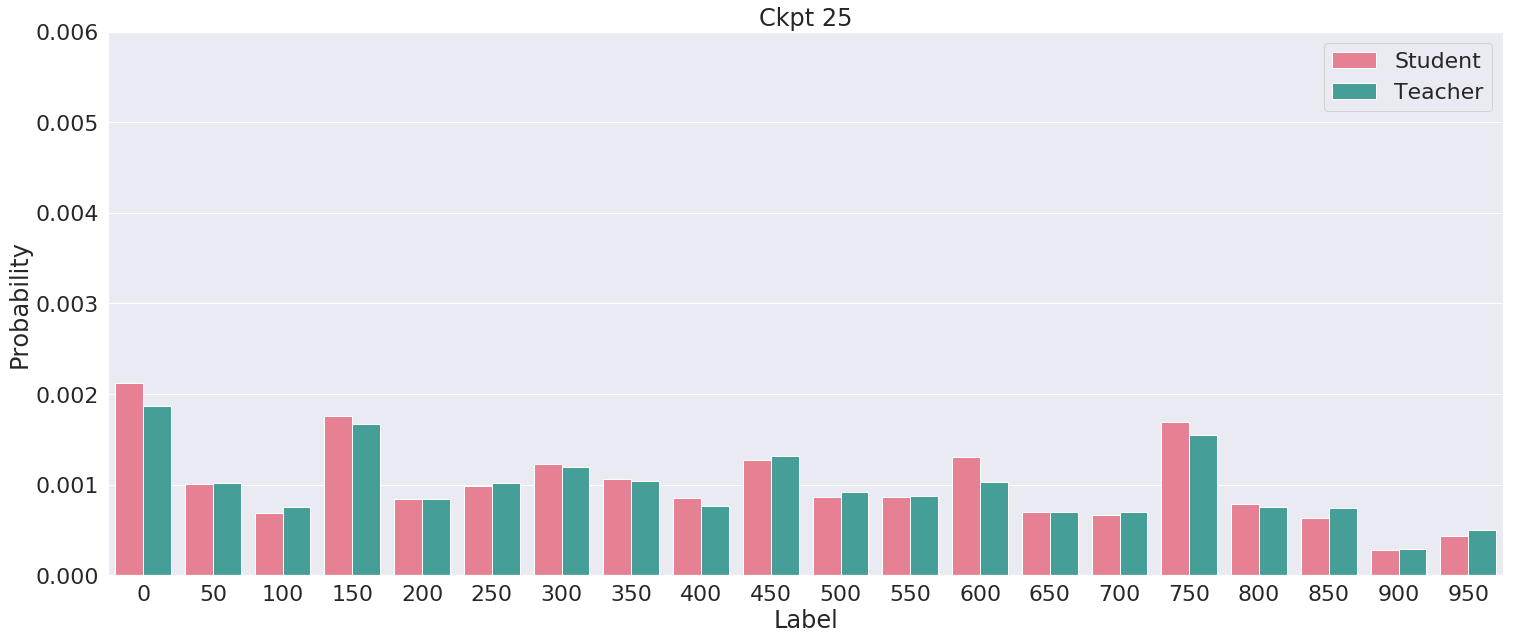

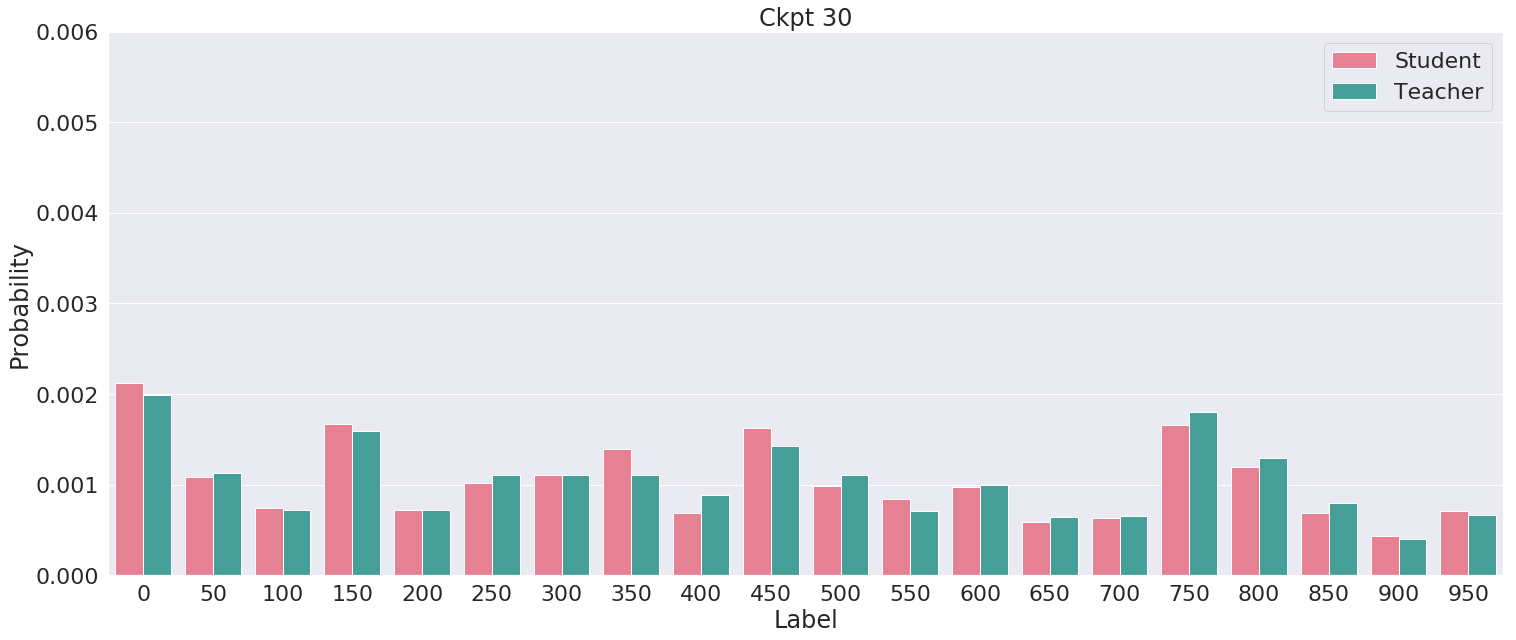

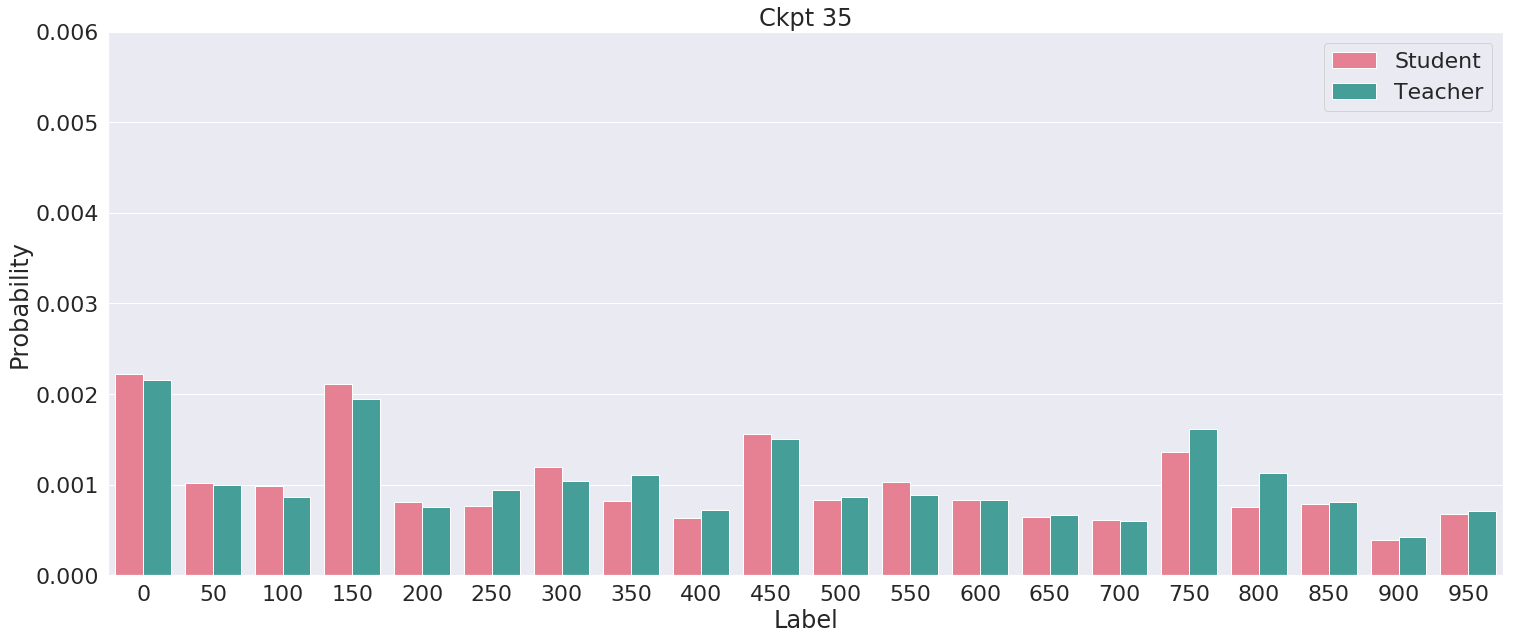

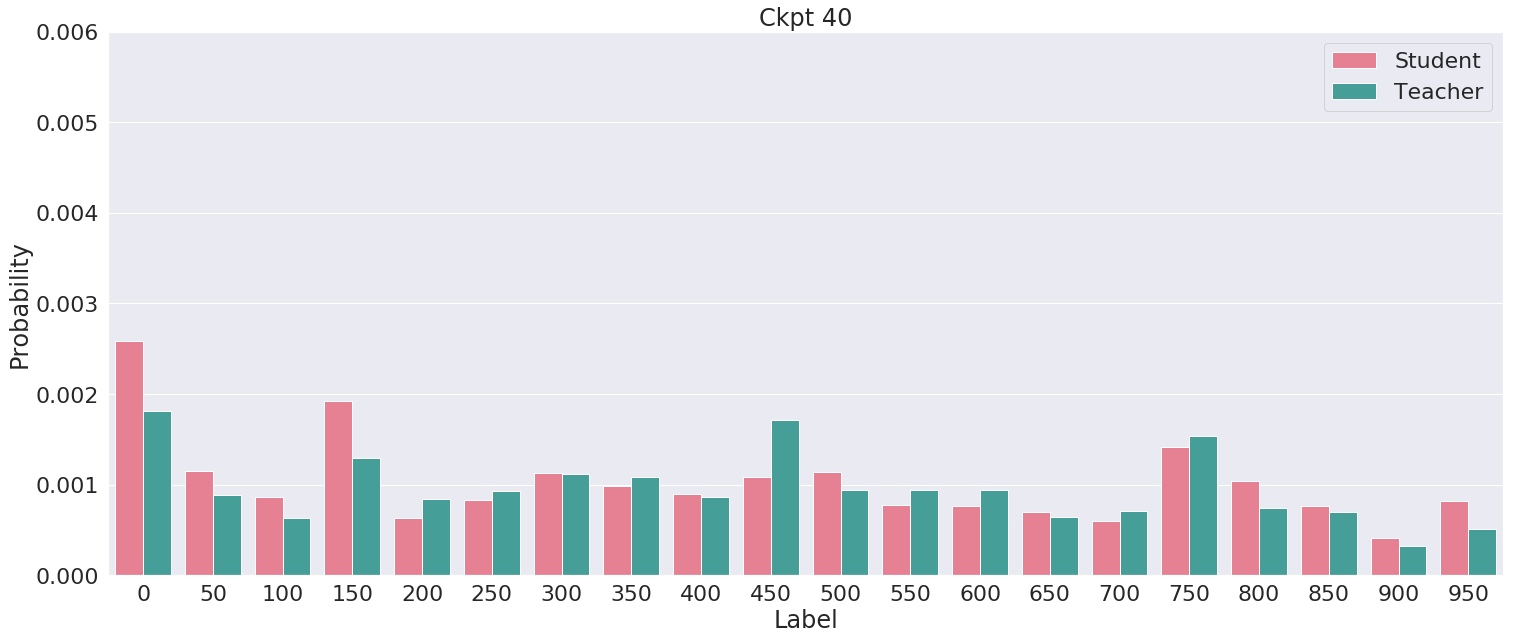

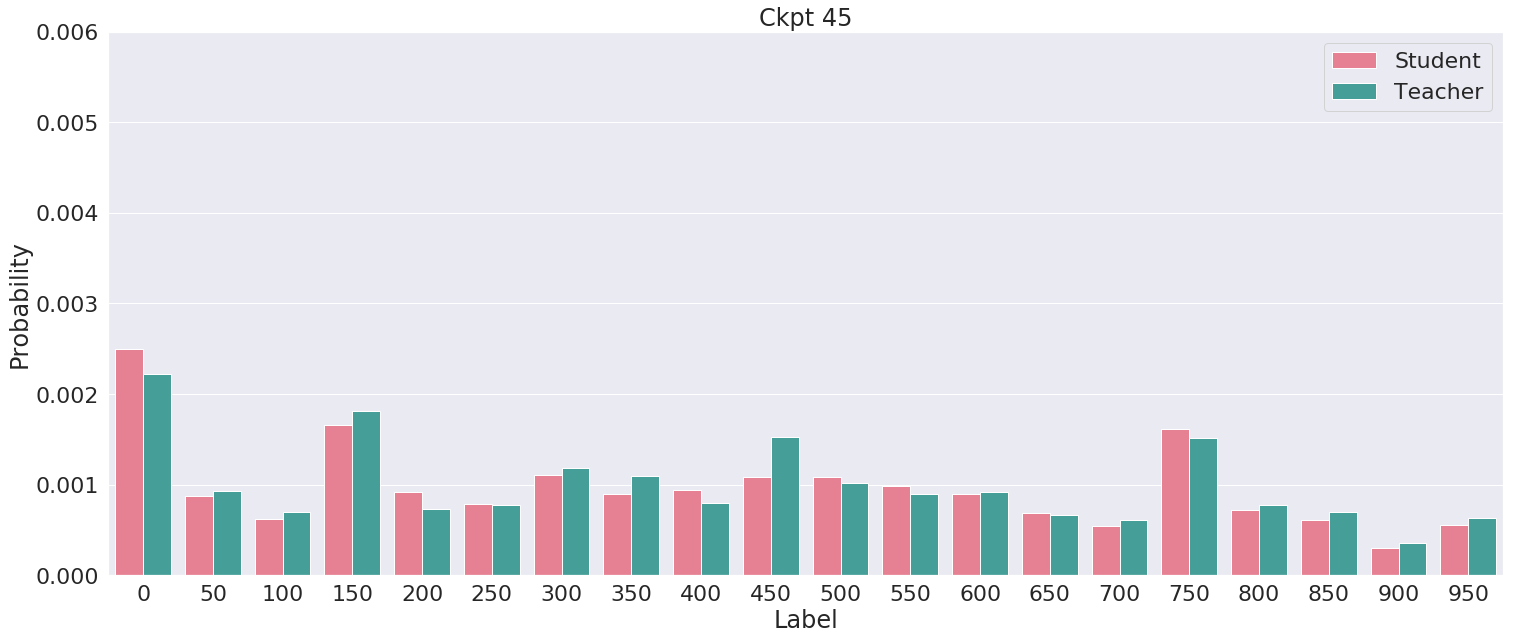

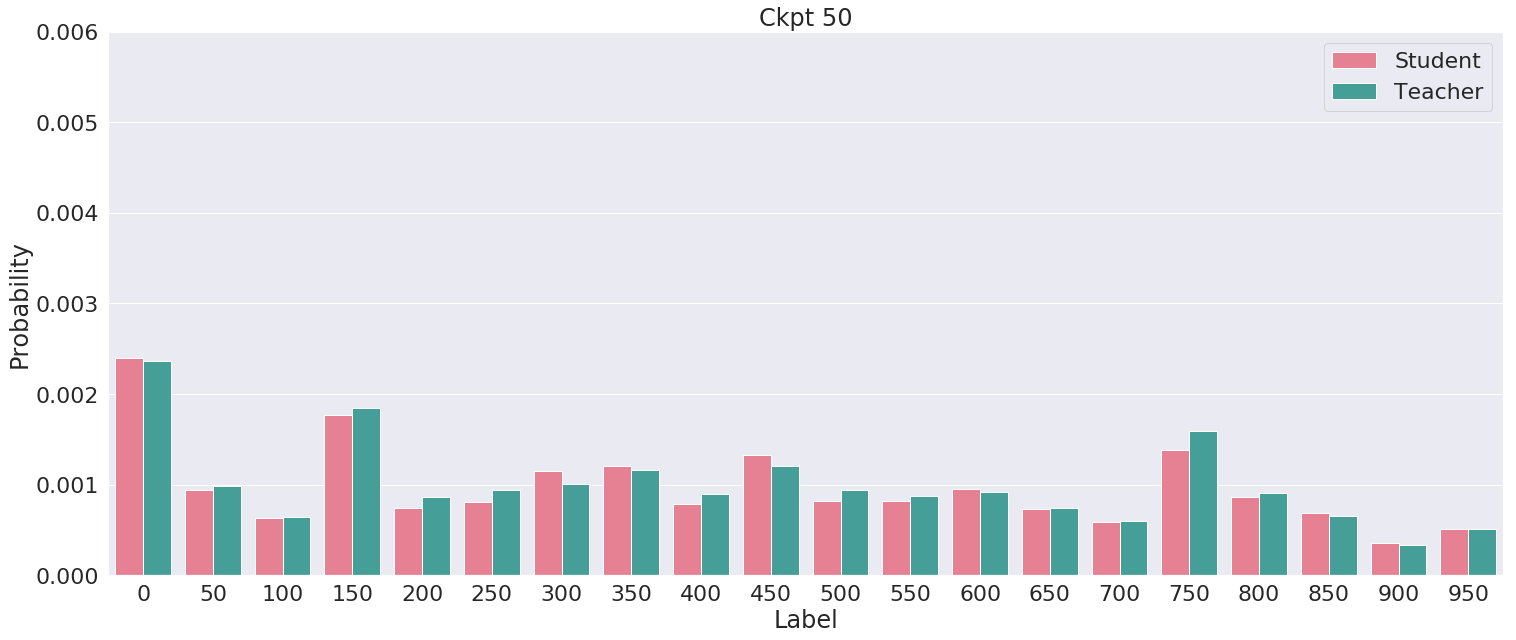

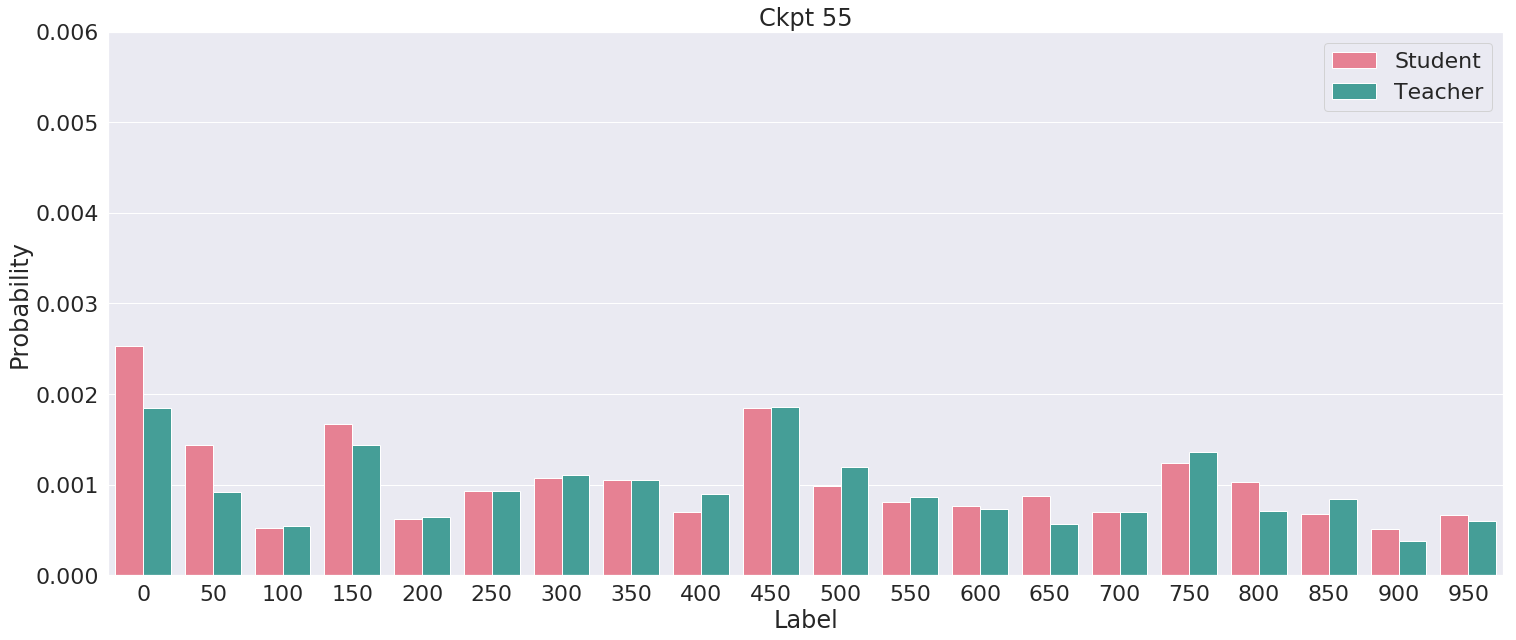

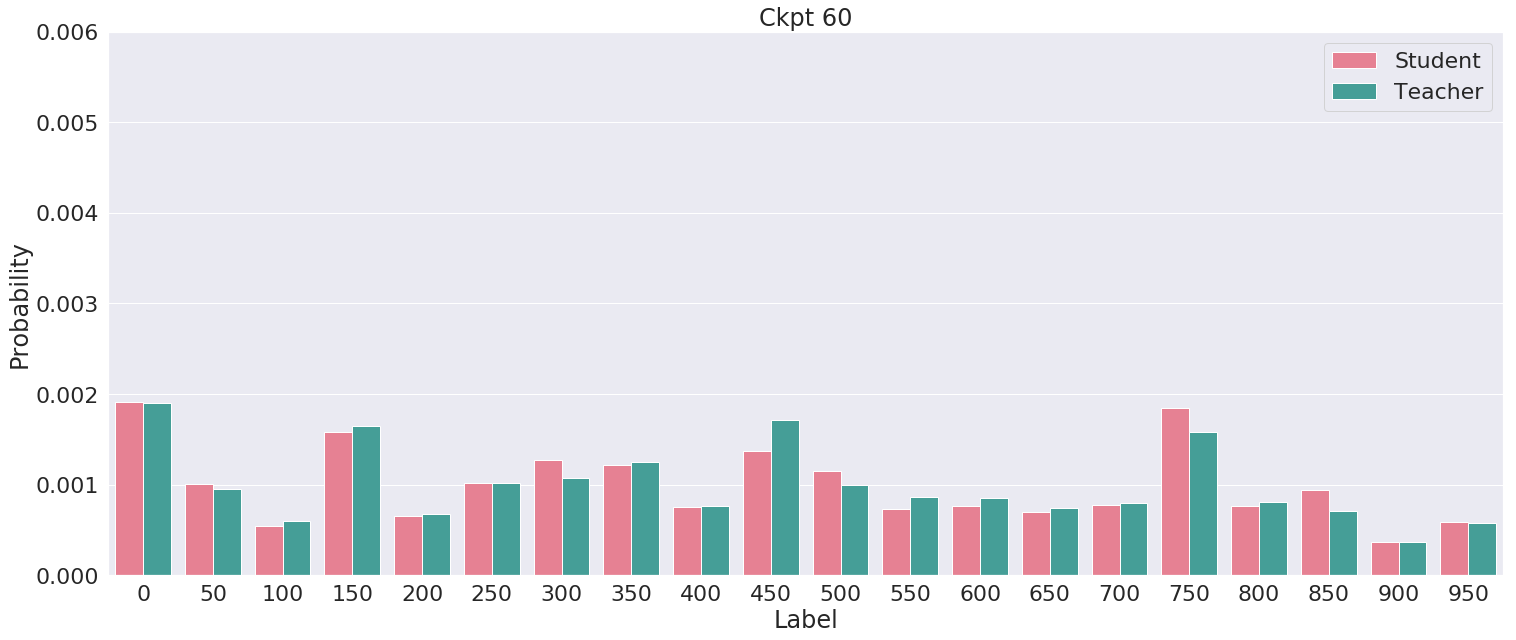

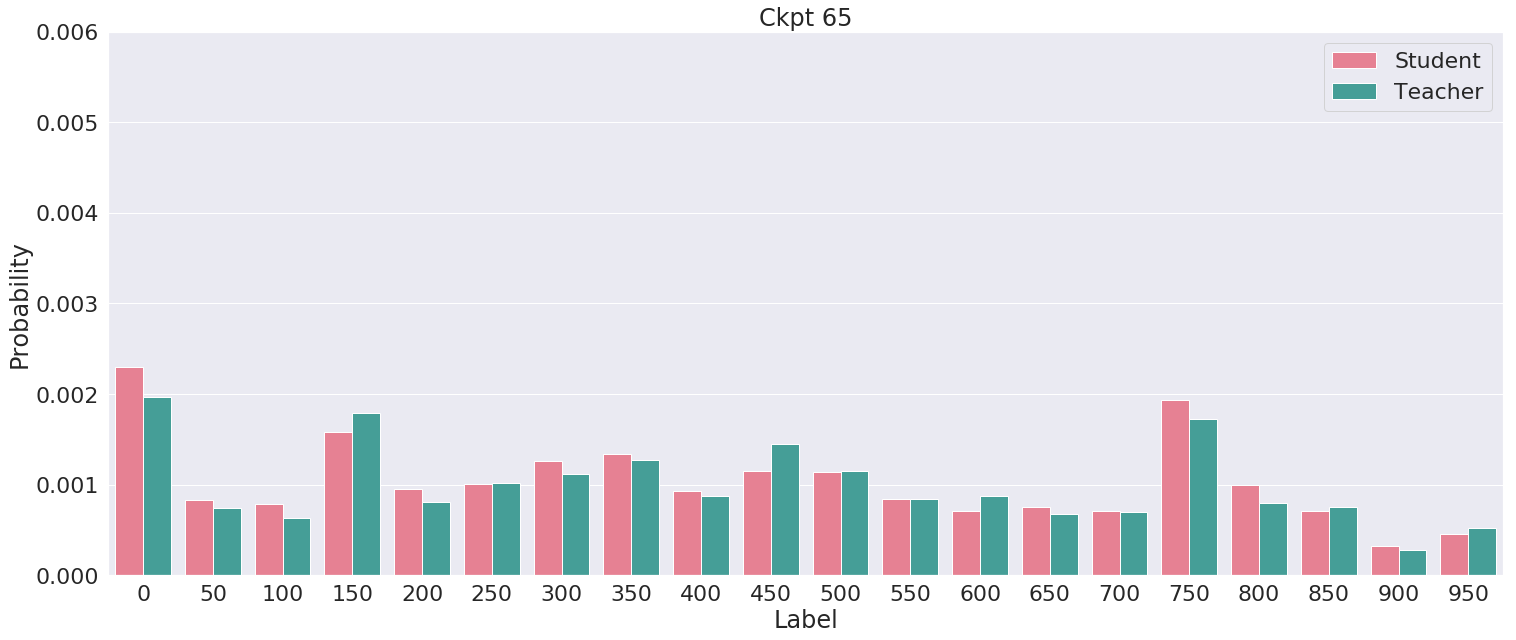

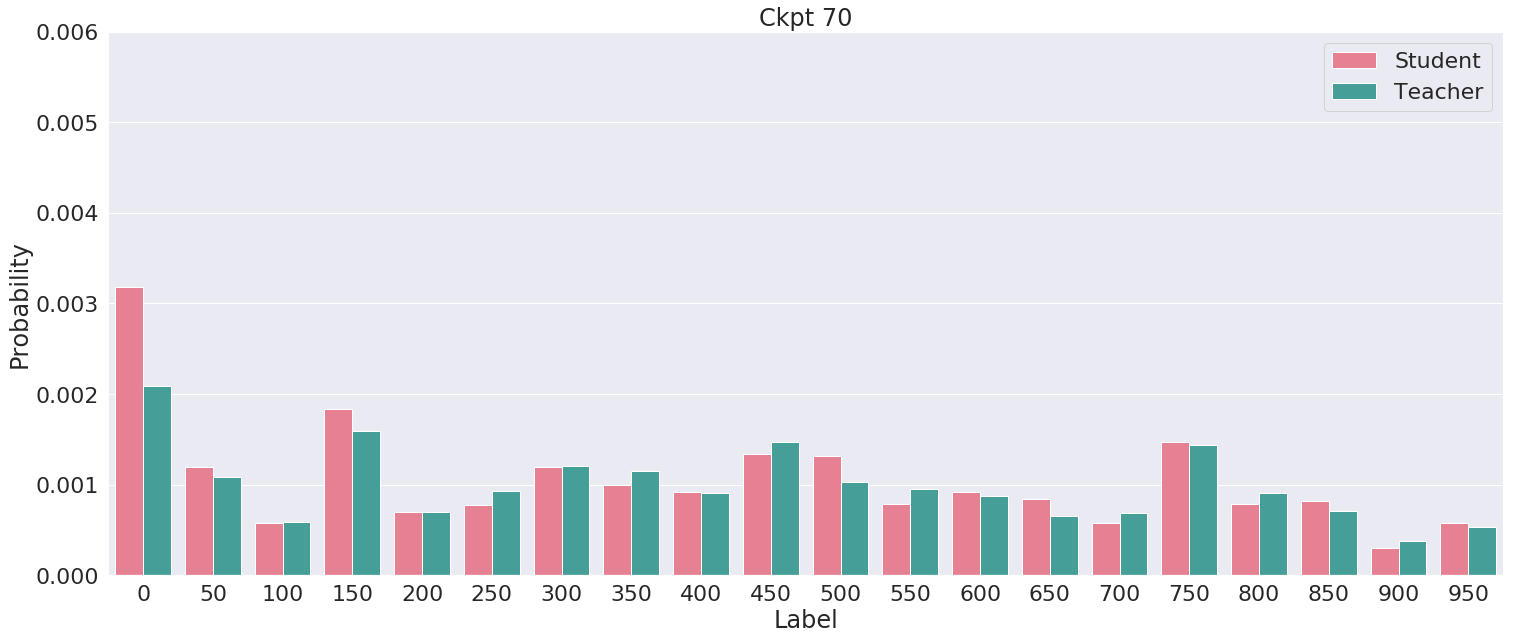

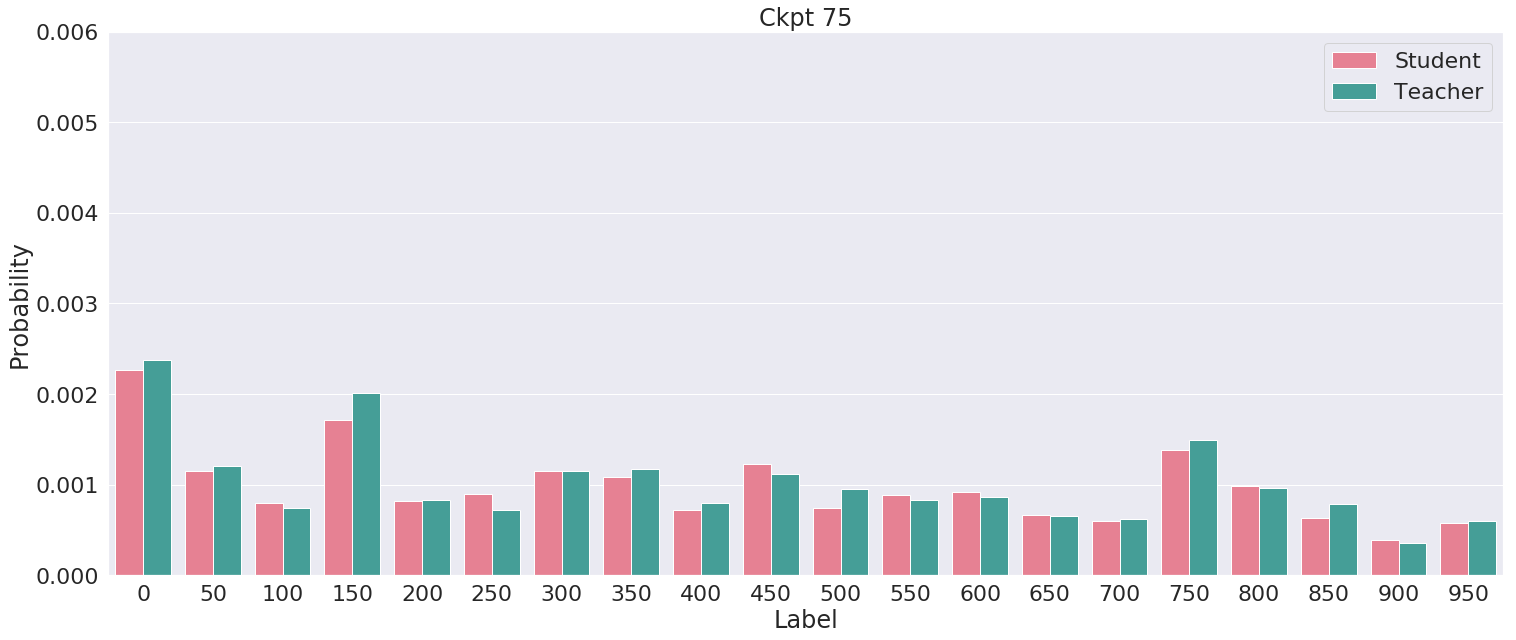

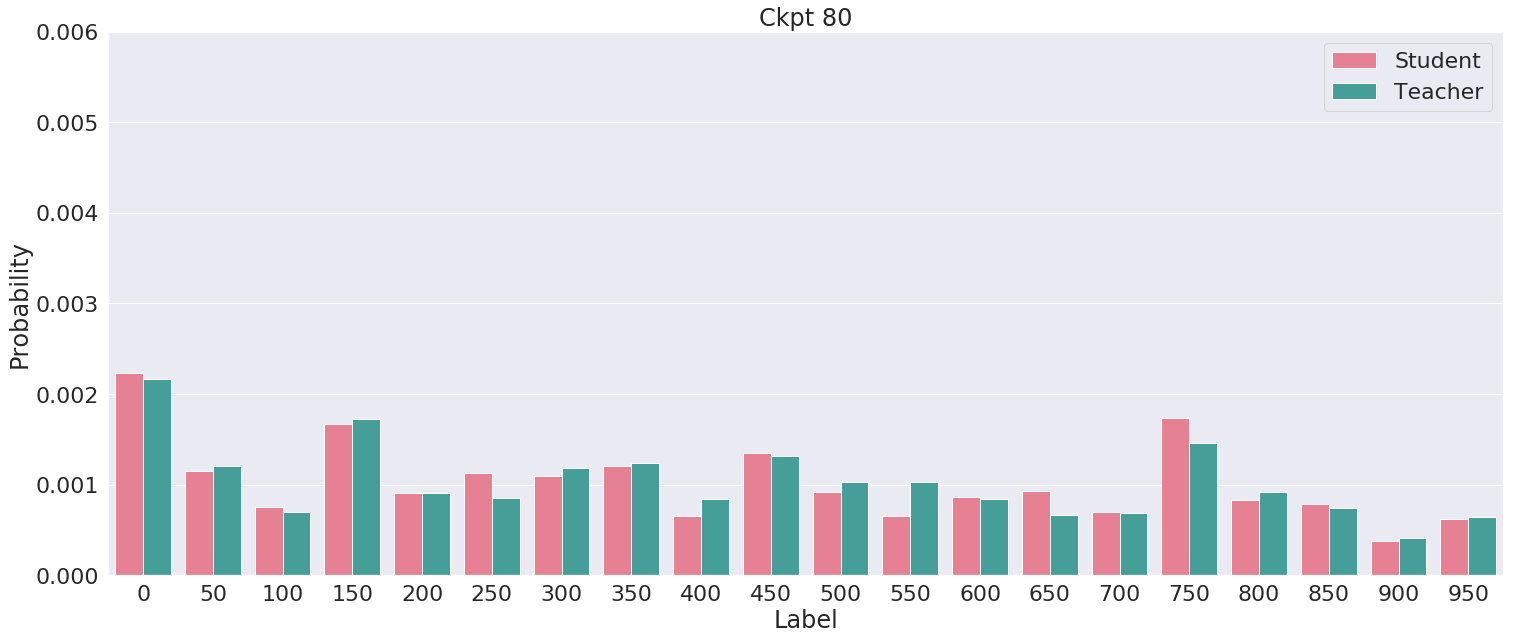

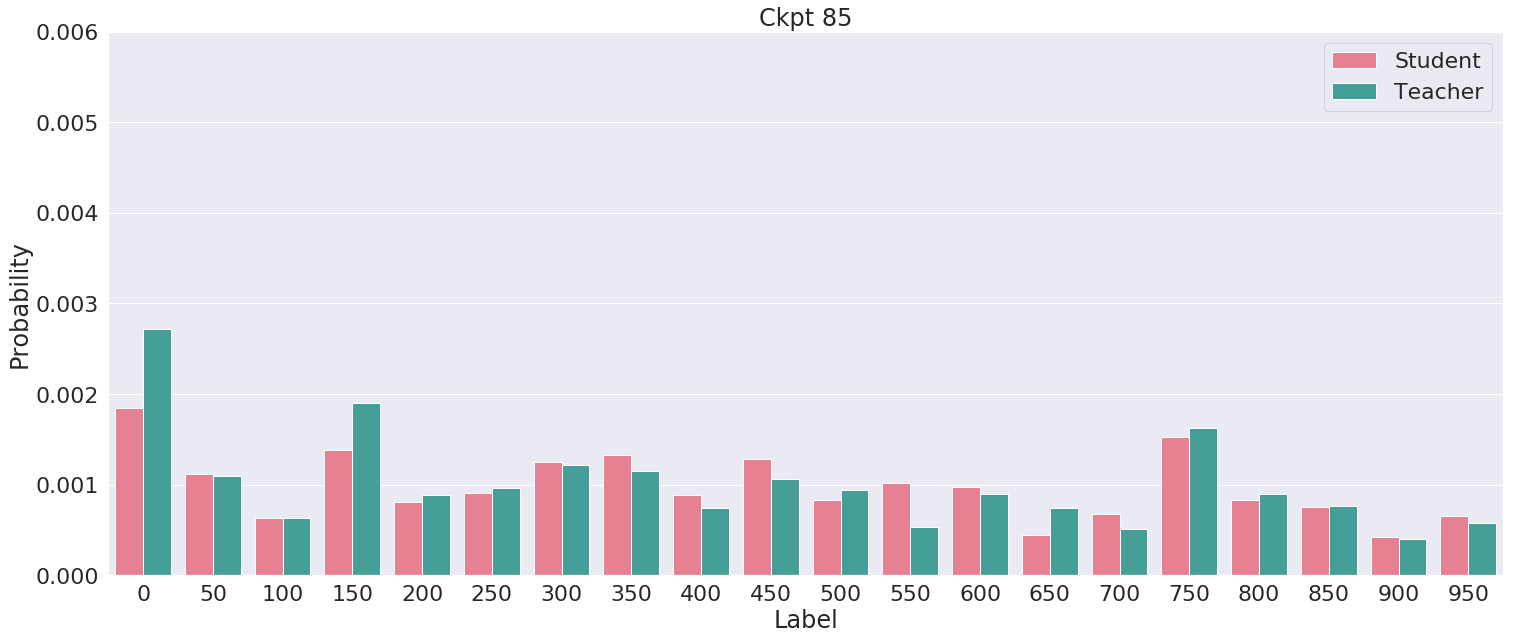

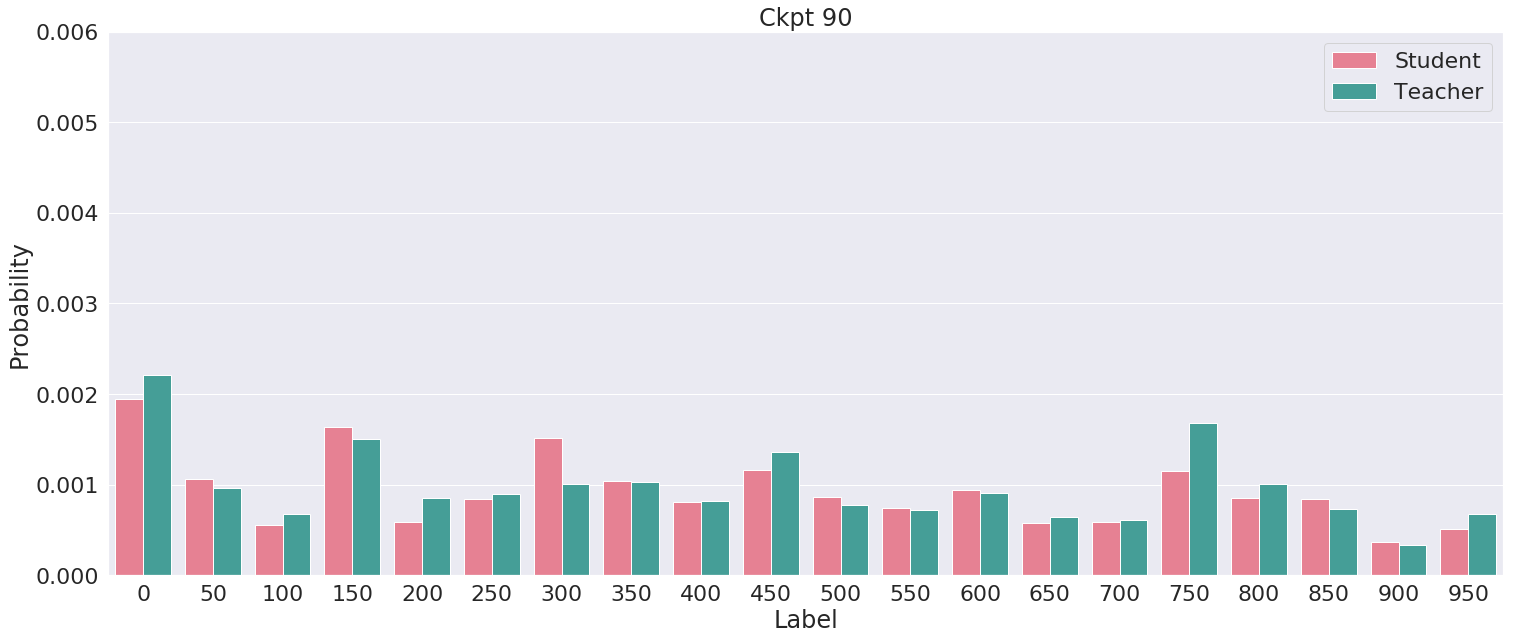

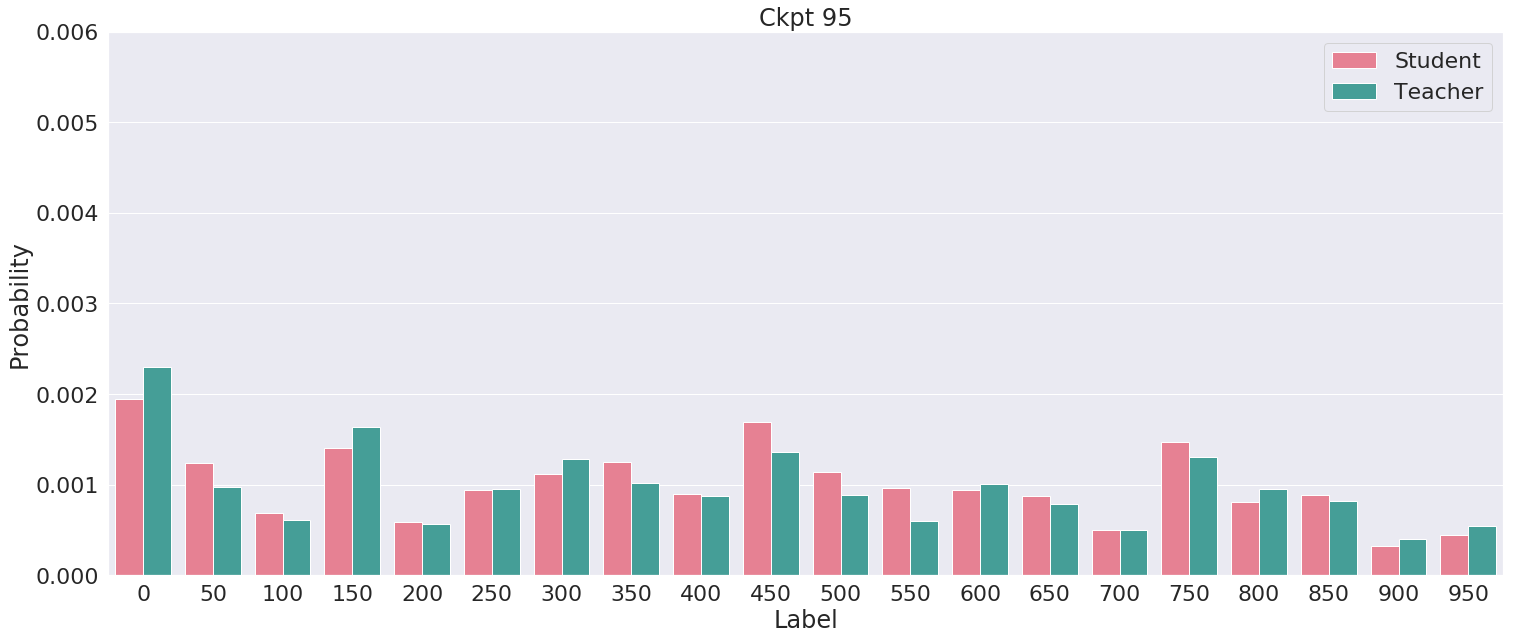

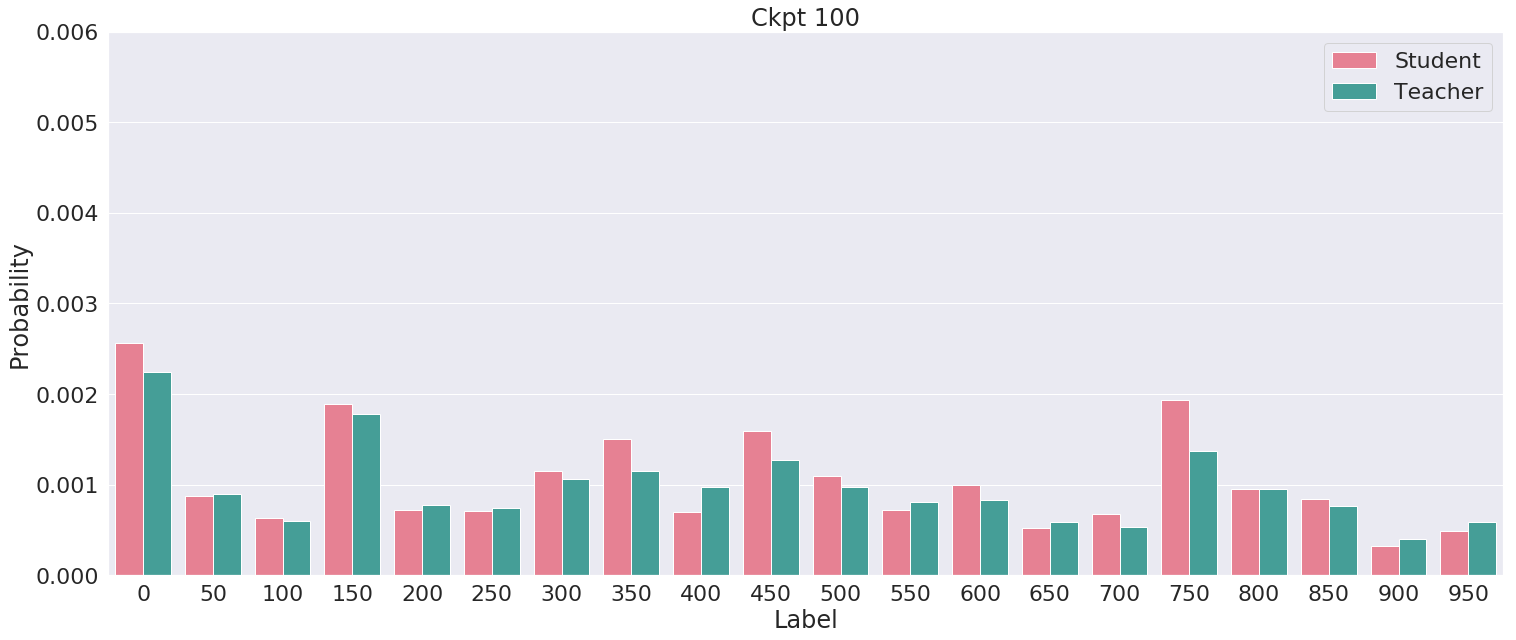

In [39]:
sns.set(font_scale=2)
sns.set_palette(sns.color_palette('husl', 2))

images = []

for i in np.arange(0, 105, 5):
    ll_tt = labels_melt.loc[(labels_melt['Ckpt']==i)&(labels_melt['Label'].isin(select_labels))].copy()
    fig = plt.figure(figsize=(25,10))
    sns.barplot(data=ll_tt, x='Label', y='Probability', hue="Model")
    plt.ylim((0, 0.006))
    plt.legend()
    plt.title("Ckpt {}".format(i))
    plt.savefig("viz2/ckptBar{}.png".format(i))
    
    images.append(imageio.imread("viz2/ckptBar{}.png".format(i)))
    
imageio.mimsave('viz2/ckptBar.gif', images, fps=5)
    

In [31]:
import imageio
images = []
for i in np.arange(0, 105, 5):
    filename = "viz/ckpt{}.png".format(i)
    images.append(imageio.imread(filename))

In [34]:
imageio.mimsave('viz/ckpt.gif', images, fps=5)

<Figure size 2520x3240 with 0 Axes>

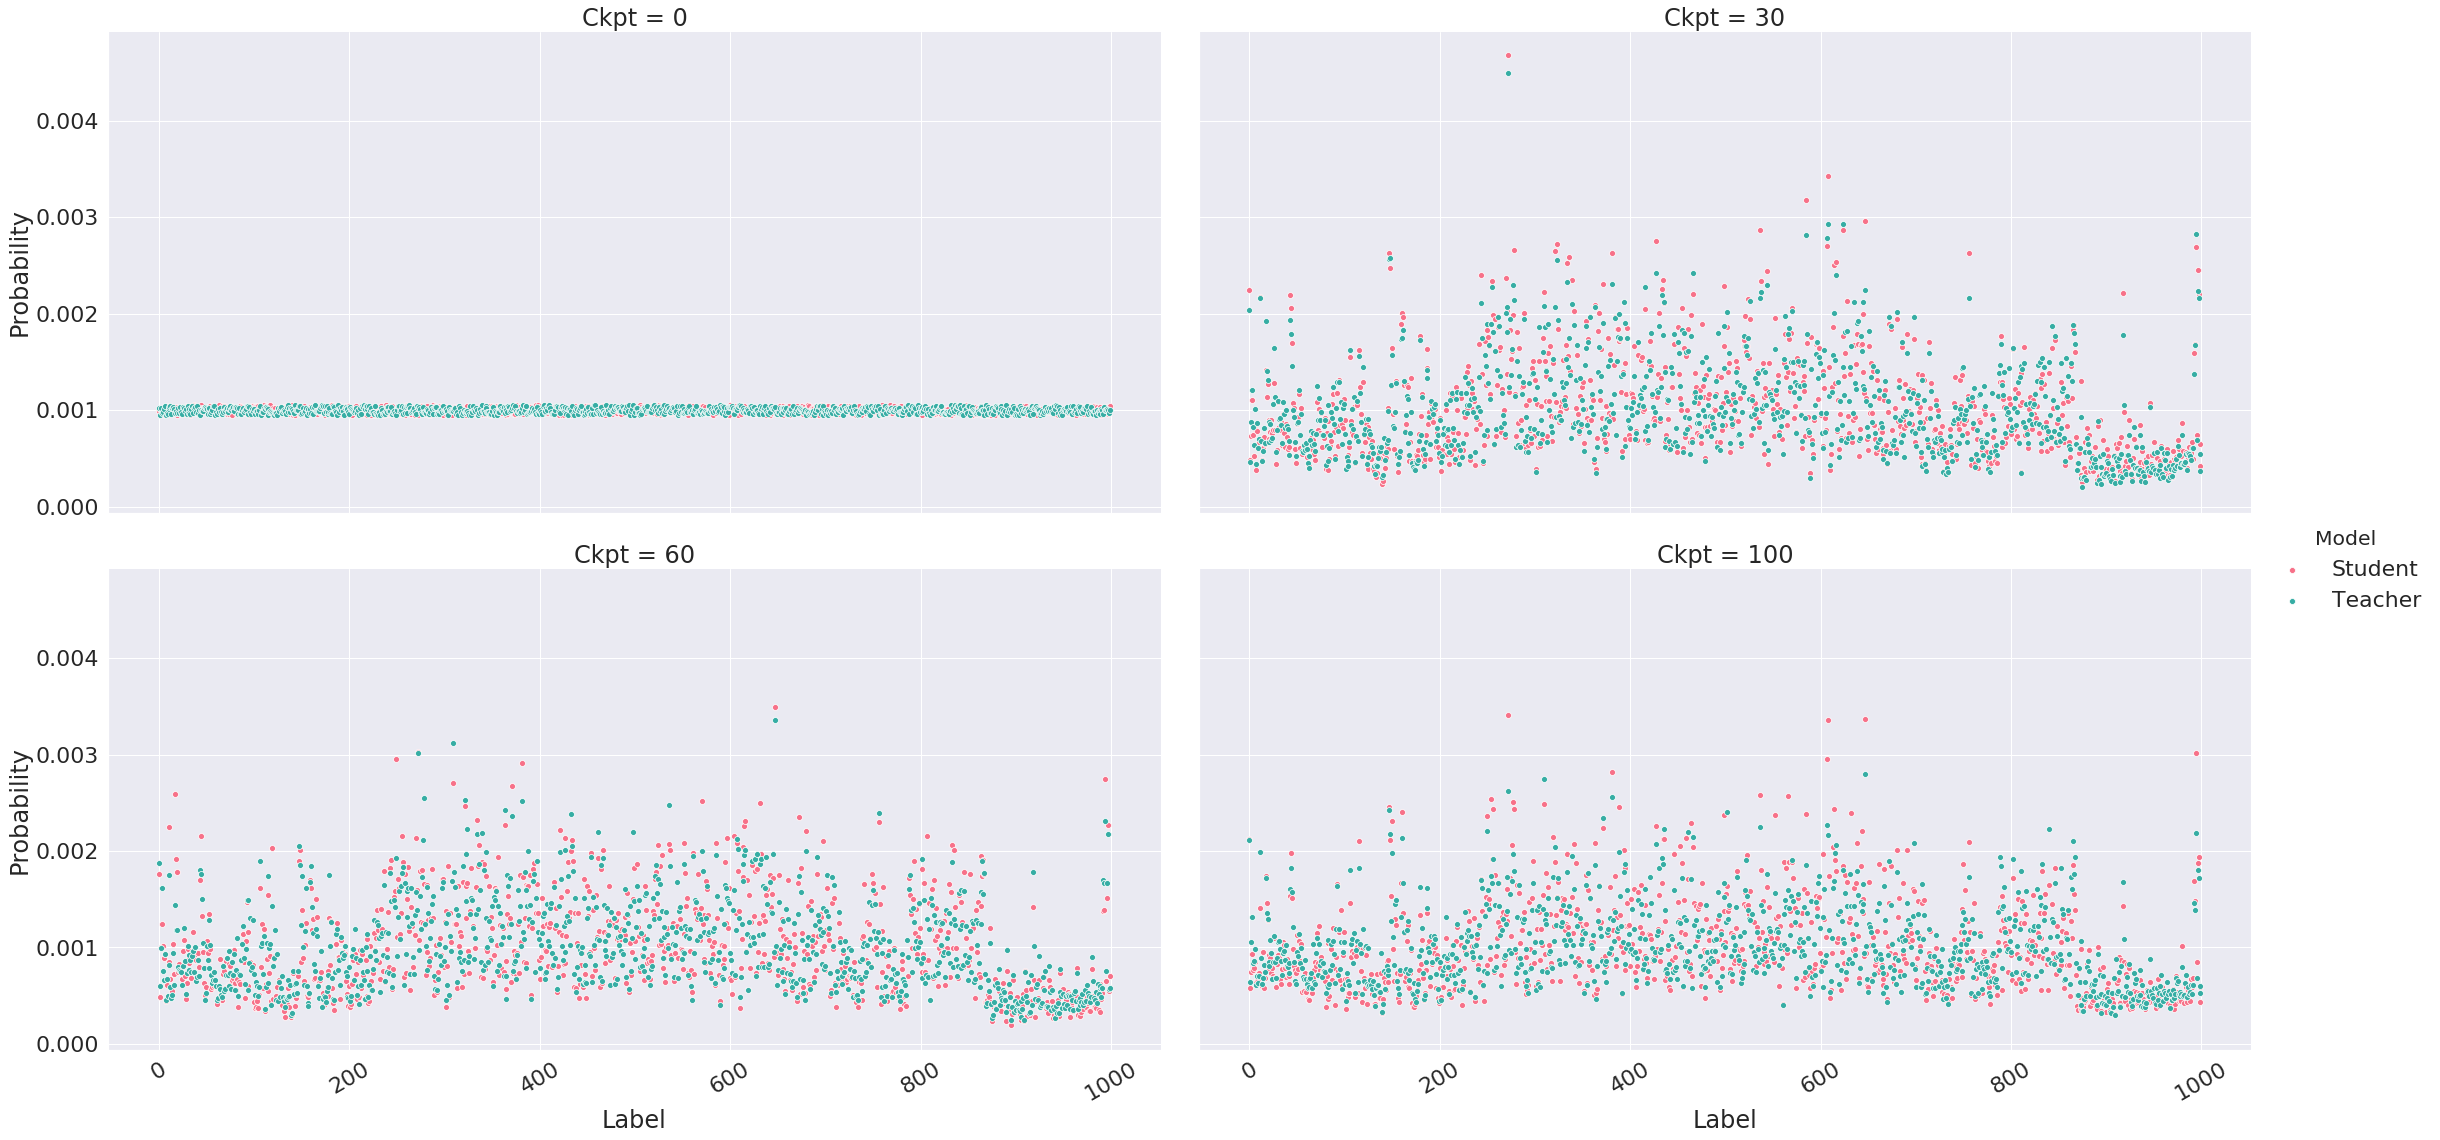

In [144]:

sns.set(font_scale=2)
sns.set_palette(sns.color_palette('husl', 2))

fig = plt.figure(figsize=(35,45))
fig.tight_layout()
g = sns.FacetGrid(labels_melt,
                  col='Ckpt',
                  hue='Model', 
                  col_wrap=2,
                  height=8,
                  aspect=2
                 )
g = g.map(sns.scatterplot, "Label", "Probability", label="Model")
g.set_xticklabels(rotation=30)
g.add_legend()